# Task1

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata, entropy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
from mpl_toolkits.mplot3d import Axes3D

# 忽略数值计算警告
warnings.filterwarnings('ignore')

# -----------------------
# 全局常量
# -----------------------
TOTAL_VOTES = 10_000_000  # 假设每周 3000 万票
SEED = 2026

# -----------------------
# 0) 数据结构与预处理
# -----------------------

@dataclass
class WeekEvent:
    season: int
    week: int
    rule: str               # "RANK", "PERCENT", "BOTTOM2"
    active_names: List[str] # 当周参赛选手
    eliminated: List[str]   # 当周淘汰者
    j_scores: np.ndarray    # 评委原始分
    j_percent: np.ndarray   # 评委分占比
    j_rank: np.ndarray      # 评委排名 (1=Best)
    placements: np.ndarray  # [核心修复] 最终名次 (1=Winner, 999=Unknown)
    k_elim: int             # 淘汰人数
    is_z_week: bool         # 是否无淘汰周

def get_season_rule(season: int) -> str:
    if season <= 2: return "RANK"
    elif season <= 27: return "PERCENT"
    else: return "BOTTOM2"  # S28+

def calculate_ranks_desc(scores: np.ndarray) -> np.ndarray:
    """计算排名：分数越高，排名越小(1)。"""
    return rankdata(-scores, method='min')

def load_data(csv_path: str, target_seasons: List[int]) -> Tuple[pd.DataFrame, Dict[Tuple[int, int], WeekEvent]]:
    df = pd.read_csv(csv_path)
    
    # [核心修复] 解析 placement 列，处理非数值情况
    def safe_parse_place(x):
        try:
            return float(x)
        except:
            return 999.0 # 无效或未知的名次
            
    df['placement_num'] = df['placement'].apply(safe_parse_place).fillna(999.0)

    # 转长表
    week_cols = [c for c in df.columns if "week" in c and "judge" in c]
    long_df = df.melt(
        id_vars=["season", "celebrity_name", "results", "placement_num"],
        value_vars=week_cols,
        var_name="wk_str", value_name="score"
    )
    long_df["week"] = long_df["wk_str"].str.extract(r"week(\d+)_").astype(int)
    long_df["score"] = pd.to_numeric(long_df["score"], errors="coerce")
    
    # 聚合每周总分
    wk_tot = long_df.groupby(["season", "week", "celebrity_name", "results", "placement_num"])["score"].sum(min_count=1).reset_index()
    
    # 标记 Active (分数 > 0)
    wk_tot = wk_tot[wk_tot["score"].fillna(0) > 0].copy()
    
    # 解析淘汰周
    def parse_elim(res, wk):
        if pd.isna(res): return False
        s_res = str(res)
        if "Eliminated Week" in s_res:
            try:
                elim_w = int(s_res.split("Week ")[1])
                return elim_w == wk
            except: return False
        return False

    wk_tot["is_elim"] = wk_tot.apply(lambda x: parse_elim(x["results"], x["week"]), axis=1)

    events = {}
    for (s, w), g in wk_tot.groupby(["season", "week"]):
        if s not in target_seasons: continue
        
        # 按名字排序确保索引对齐
        g = g.sort_values("celebrity_name")
        
        names = g["celebrity_name"].tolist()
        scores = g["score"].values
        elim_names = g[g["is_elim"]]["celebrity_name"].tolist()
        places = g["placement_num"].values # 提取名次
        
        # 计算评委指标
        j_sum = scores.sum()
        j_percent = scores / j_sum if j_sum > 0 else np.zeros_like(scores)
        j_rank = calculate_ranks_desc(scores)
        
        rule = get_season_rule(s)
        
        events[(s, w)] = WeekEvent(
            season=s, week=w, rule=rule,
            active_names=names,
            eliminated=elim_names,
            j_scores=scores,
            j_percent=j_percent,
            j_rank=j_rank,
            placements=places, # 存入事件
            k_elim=len(elim_names),
            is_z_week=(len(elim_names) == 0)
        )
        
    return wk_tot, events

# -----------------------
# 1) 模型 A：优化 (Max Entropy + Smoothing + Rank Constraints)
# -----------------------
def estimate_model_a(season_events: List[WeekEvent], smooth_lambda=50.0) -> pd.DataFrame:
    # 确保按周排序
    season_events.sort(key=lambda x: x.week)
    results = []
    
    for ev in season_events:
        n = len(ev.active_names)
        # 初始猜测：均匀分布
        x0 = np.ones(n) / n
        
        def obj_func(v):
            # 最大熵目标 + 平滑正则
            ent = np.sum(v * np.log(v + 1e-9)) 
            reg = np.sum((v - 1/n)**2)
            return ent + smooth_lambda * reg

        # 基础约束: 概率和为 1
        cons = [{'type': 'eq', 'fun': lambda v: np.sum(v) - 1.0}]
        
        # --- 约束 1: 淘汰生存 (幸存者 > 淘汰者) ---
        if ev.k_elim > 0:
            elim_indices = [i for i, name in enumerate(ev.active_names) if name in ev.eliminated]
            safe_indices = [i for i, name in enumerate(ev.active_names) if name not in ev.eliminated]
            
            if safe_indices:
                for ei in elim_indices:
                    for si in safe_indices:
                        # 逻辑：Total(Safe) >= Total(Elim)
                        diff_j = ev.j_percent[si] - ev.j_percent[ei]
                        cons.append({'type': 'ineq', 'fun': lambda v, si=si, ei=ei, dj=diff_j: v[si] - v[ei] + dj})

        # --- [新增] 约束 2: 同周淘汰者内部排序 (Better Place > Worse Place) ---
        if ev.k_elim > 1:
            elim_indices = [i for i, name in enumerate(ev.active_names) if name in ev.eliminated]
            elim_with_place = []
            for idx in elim_indices:
                place = ev.placements[idx]
                if place != 999: # 过滤无效名次
                    elim_with_place.append((idx, place))
            
            # 按名次升序 (1st, 2nd...)
            elim_with_place.sort(key=lambda x: x[1])
            
            for k in range(len(elim_with_place) - 1):
                best_i, best_p = elim_with_place[k]
                worse_i, worse_p = elim_with_place[k+1]
                if best_p < worse_p:
                    diff_j = ev.j_percent[best_i] - ev.j_percent[worse_i]
                    cons.append({'type': 'ineq', 'fun': lambda v, bi=best_i, wi=worse_i, dj=diff_j: v[bi] - v[wi] + dj})

        # --- 约束 3: 决赛/全局名次软约束 ---
        ranked_indices = [i for i, p in enumerate(ev.placements) if p != 999]
        if len(ranked_indices) > 1:
            sorted_idx = sorted(ranked_indices, key=lambda i: ev.placements[i])
            for k in range(len(sorted_idx) - 1):
                best_i = sorted_idx[k]
                worse_i = sorted_idx[k+1]
                diff_j = ev.j_percent[best_i] - ev.j_percent[worse_i]
                # 给予 0.1% 容错，避免与硬约束冲突
                cons.append({'type': 'ineq', 'fun': lambda v, bi=best_i, wi=worse_i, dj=diff_j: v[bi] - v[wi] + dj + 0.001})

        bounds = [(1e-4, 1.0) for _ in range(n)]
        
        # 求解
        res = minimize(obj_func, x0, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter': 200})
        
        v_hat = res.x / res.x.sum()
        for i, name in enumerate(ev.active_names):
            results.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "vote_share_A": v_hat[i],
                "model_a_success": res.success
            })
    
    return pd.DataFrame(results)

# -----------------------
# 2) 模型 B：贝叶斯 MAP + 采样 (Ranking Likelihood)
# -----------------------
def estimate_model_b(season_events: List[WeekEvent], 
                     sigma_rw=0.5, kappa=40.0, n_samples=500) -> Tuple[pd.DataFrame, pd.DataFrame]:
    season_events.sort(key=lambda x: x.week)
    
    # 1. 参数映射
    unique_keys = []
    for ev in season_events:
        for name in ev.active_names:
            unique_keys.append((ev.week, name))
    unique_keys = list(dict.fromkeys(unique_keys))
    key_to_idx = {k: i for i, k in enumerate(unique_keys)}
    n_params = len(unique_keys)
    
    def get_indices(ev):
        return [key_to_idx[(ev.week, n)] for n in ev.active_names]

    def softmax(u):
        e = np.exp(u - np.max(u))
        return e / np.sum(e)

    # 2. 后验函数
    def neg_log_posterior(u_vec):
        loss = 0.0
        
        # A. Prior: Random Walk
        player_dict = {}
        for (wk, name), idx in key_to_idx.items():
            player_dict.setdefault(name, []).append((wk, idx))
            
        for name, seq in player_dict.items():
            seq.sort()
            for k in range(len(seq) - 1):
                w1, idx1 = seq[k]
                w2, idx2 = seq[k+1]
                if w2 == w1 + 1:
                    loss += 0.5 * ((u_vec[idx2] - u_vec[idx1]) / sigma_rw) ** 2
        
        # B, C, D. Likelihoods
        for ev in season_events:
            idxs = get_indices(ev)
            current_u = u_vec[idxs]
            v_share = softmax(current_u)
            # --- Likelihood B: 幸存者 vs 淘汰者 ---
            if ev.k_elim > 0:
                elim_idxs = [i for i, n in enumerate(ev.active_names) if n in ev.eliminated]
                safe_idxs = [i for i, n in enumerate(ev.active_names) if n not in ev.eliminated]
                
                if elim_idxs and safe_idxs:
                    for ei in elim_idxs:
                        score_e = ev.j_percent[ei] + v_share[ei]
                        for si in safe_idxs:
                            score_s = ev.j_percent[si] + v_share[si]
                            diff = score_s - score_e
                            loss += np.log(1 + np.exp(-kappa * diff))
         # --- [新增] Likelihood D: 同周淘汰者内部排序 ---
            if ev.k_elim > 1:
                elim_idxs = [i for i, n in enumerate(ev.active_names) if n in ev.eliminated]
                
                elim_subset = []
                for idx in elim_idxs:
                    place = ev.placements[idx]
                    if place != 999:
                        elim_subset.append((idx, place))
                
                elim_subset.sort(key=lambda x: x[1])
                
                for k in range(len(elim_subset) - 1):
                    bi, bp = elim_subset[k]   # Better
                    wi, wp = elim_subset[k+1] # Worse
                    
                    if bp < wp:
                        score_b = ev.j_percent[bi] + v_share[bi]
                        score_w = ev.j_percent[wi] + v_share[wi]
                        diff = score_b - score_w
                        loss += np.log(1 + np.exp(-kappa * 1.5 * diff))
             # --- Likelihood C: 全局名次顺序 ---
            ranked_indices = [i for i, p in enumerate(ev.placements) if p != 999]
            if len(ranked_indices) > 1:
                sorted_idx = sorted(ranked_indices, key=lambda i: ev.placements[i])
                for k in range(len(sorted_idx) - 1):
                    bi = sorted_idx[k]     
                    wi = sorted_idx[k+1]   
                    score_b = ev.j_percent[bi] + v_share[bi]
                    score_w = ev.j_percent[wi] + v_share[wi]
                    diff = score_b - score_w
                    loss += np.log(1 + np.exp(-kappa * diff))

        loss += 1e-4 * np.sum(u_vec**2) # L2 Regularization
        return loss

    # 3. 优化与采样
    u0 = np.zeros(n_params)
    res = minimize(neg_log_posterior, u0, method='L-BFGS-B', options={'maxiter': 1000})
    u_map = res.x
    
    # Laplace Approximation
    h = 1e-3
    hess_diag = []
    base_loss = neg_log_posterior(u_map)
    for i in range(n_params):
        u_p = u_map.copy(); u_p[i] += h
        u_m = u_map.copy(); u_m[i] -= h
        l_p = neg_log_posterior(u_p)
        l_m = neg_log_posterior(u_m)
        d2 = max((l_p + l_m - 2*base_loss)/(h**2), 1e-2)
        hess_diag.append(d2)
    std_vec = 1.0 / np.sqrt(np.array(hess_diag))
    
    rng = np.random.default_rng(SEED)
    samples = rng.normal(u_map, std_vec, size=(n_samples, n_params))
    
    map_rows = []
    unc_rows = []
    
    for ev in season_events:
        idxs = get_indices(ev)
        v_map_val = softmax(u_map[idxs])
        v_samples_block = np.array([softmax(row[idxs]) for row in samples])
        
        for i, name in enumerate(ev.active_names):
            map_rows.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "vote_share_B": v_map_val[i]
            })
            
            mean_v = np.mean(v_samples_block[:, i])
            std_v = np.std(v_samples_block[:, i])
            unc_rows.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "mean_share": mean_v, "std_share": std_v, 
                "low_share": np.percentile(v_samples_block[:, i], 5), 
                "high_share": np.percentile(v_samples_block[:, i], 95),
                "cv": std_v / (mean_v + 1e-9)
            })
            
    return pd.DataFrame(map_rows), pd.DataFrame(unc_rows)

# -----------------------
# 3) 评估与辅助功能
# -----------------------
def evaluate_metrics(events: Dict, df_ens: pd.DataFrame) -> pd.DataFrame:
    metrics = []
    seasons = df_ens["season"].unique()
    
    for s in seasons:
        s_evs = [e for k, e in events.items() if k[0] == s]
        s_evs.sort(key=lambda x: x.week)
        hits, total_elim = 0, 0
        margins = []
        
        for ev in s_evs:
            if ev.k_elim == 0: continue
            total_elim += 1
            sub = df_ens[(df_ens["season"] == s) & (df_ens["week"] == ev.week)]
            if sub.empty: continue
            
            name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
            v_share = np.array([name_map.get(n, 0) for n in ev.active_names])
            
            # 使用统一 Score 评估
            combined = ev.j_percent + v_share
            sorted_idx = np.argsort(combined) # 0 is lowest
            
            bottom_names = [ev.active_names[i] for i in sorted_idx[:ev.k_elim]]
            
            if set(ev.eliminated).issubset(set(bottom_names)):
                hits += 1
                
            if len(sorted_idx) > ev.k_elim:
                safe_score = combined[sorted_idx[ev.k_elim]]
                danger_score = combined[sorted_idx[ev.k_elim-1]]
                margins.append(safe_score - danger_score)
                
        metrics.append({
            "season": s,
            "hit_rate": hits / total_elim if total_elim else 0,
            "avg_margin": np.mean(margins) if margins else 0
        })
    return pd.DataFrame(metrics)

# -----------------------
# 5) 过拟合检验数据生成
# -----------------------
def analyze_entropy_overfitting(df_ens: pd.DataFrame):
    entropy_records = []
    groups = df_ens.groupby(['season', 'week'])
    
    for (s, w), g in groups:
        votes = g['vote_share_ens'].values
        votes = votes / np.sum(votes)
        n = len(votes)
        if n <= 1: continue
        
        ent = entropy(votes) # Shannon Entropy
        max_ent = np.log(n)
        norm_ent = ent / max_ent
        
        entropy_records.append({
            "season": s, "week": w, "n_candidates": n,
            "shannon_entropy": ent, "normalized_entropy": norm_ent
        })
    return pd.DataFrame(entropy_records)


## Task1模型执行计算

In [3]:
# ===========================
# 执行模型计算
# ===========================

# 1. 确认文件名 (请确保此文件在同级目录下)
csv_path = "2026_MCM_Problem_C_Data.csv"

# 可根据需要修改目标赛季
target_seasons = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34] 

print(f"[{pd.Timestamp.now()}] 开始数据处理...")

try:
    # --- 1. 加载数据 ---
    wk_tot, events = load_data(csv_path, target_seasons)
    print(f"数据加载成功! 共找到 {len(events)} 个周次事件。")
    
    all_ens = []
    all_unc = []
    
    # --- 2. 循环计算每一季 ---
    for s in target_seasons:
        s_events = [e for k, e in events.items() if k[0] == s]
        if not s_events: continue
        
        print(f"  正在计算第 {s} 季...")
        
        # Model A
        df_a = estimate_model_a(s_events, smooth_lambda=20.0)
        
        # Model B
        df_b, df_unc_s = estimate_model_b(s_events, sigma_rw=0.4, kappa=50.0)
        
        # Ensemble
        df_merge = pd.merge(df_a, df_b, on=["season", "week", "celebrity_name"])
        w_b = 0.75 
        df_merge["vote_share_ens"] = w_b * df_merge["vote_share_B"] + (1 - w_b) * df_merge["vote_share_A"]
        df_merge["votes_ens"] = df_merge["vote_share_ens"] * TOTAL_VOTES
        
        all_ens.append(df_merge)
        all_unc.append(df_unc_s)

    if not all_ens:
        raise ValueError("没有生成数据。")
        
    final_ens = pd.concat(all_ens)
    final_unc = pd.concat(all_unc)
    
    # 合并用于可视化的大表
    viz_df = pd.merge(final_ens, final_unc, on=["season", "week", "celebrity_name"])
    
    # 计算评估指标
    eval_metrics = evaluate_metrics(events, final_ens)
    ent_df = analyze_entropy_overfitting(final_ens)
    
    print("模型计算完成。准备绘图。")

   
    

except FileNotFoundError:
    print(f"❌ 找不到文件 '{csv_path}'。请确保文件在当前目录。")
except Exception as e:
    import traceback
    print(f"❌ 异常: {e}")
    print(traceback.format_exc())


[2026-02-01 15:31:22.463669] 开始数据处理...
数据加载成功! 共找到 335 个周次事件。
  正在计算第 1 季...
  正在计算第 2 季...
  正在计算第 3 季...
  正在计算第 4 季...
  正在计算第 5 季...
  正在计算第 6 季...
  正在计算第 7 季...
  正在计算第 8 季...
  正在计算第 9 季...
  正在计算第 10 季...
  正在计算第 11 季...
  正在计算第 12 季...
  正在计算第 13 季...
  正在计算第 14 季...
  正在计算第 15 季...
  正在计算第 16 季...
  正在计算第 17 季...
  正在计算第 18 季...
  正在计算第 19 季...
  正在计算第 20 季...
  正在计算第 21 季...
  正在计算第 22 季...
  正在计算第 23 季...
  正在计算第 24 季...
  正在计算第 25 季...
  正在计算第 26 季...
  正在计算第 27 季...
  正在计算第 28 季...
  正在计算第 29 季...
  正在计算第 30 季...
  正在计算第 31 季...
  正在计算第 32 季...
  正在计算第 33 季...
  正在计算第 34 季...
模型计算完成。准备绘图。


## Task1绘图模块

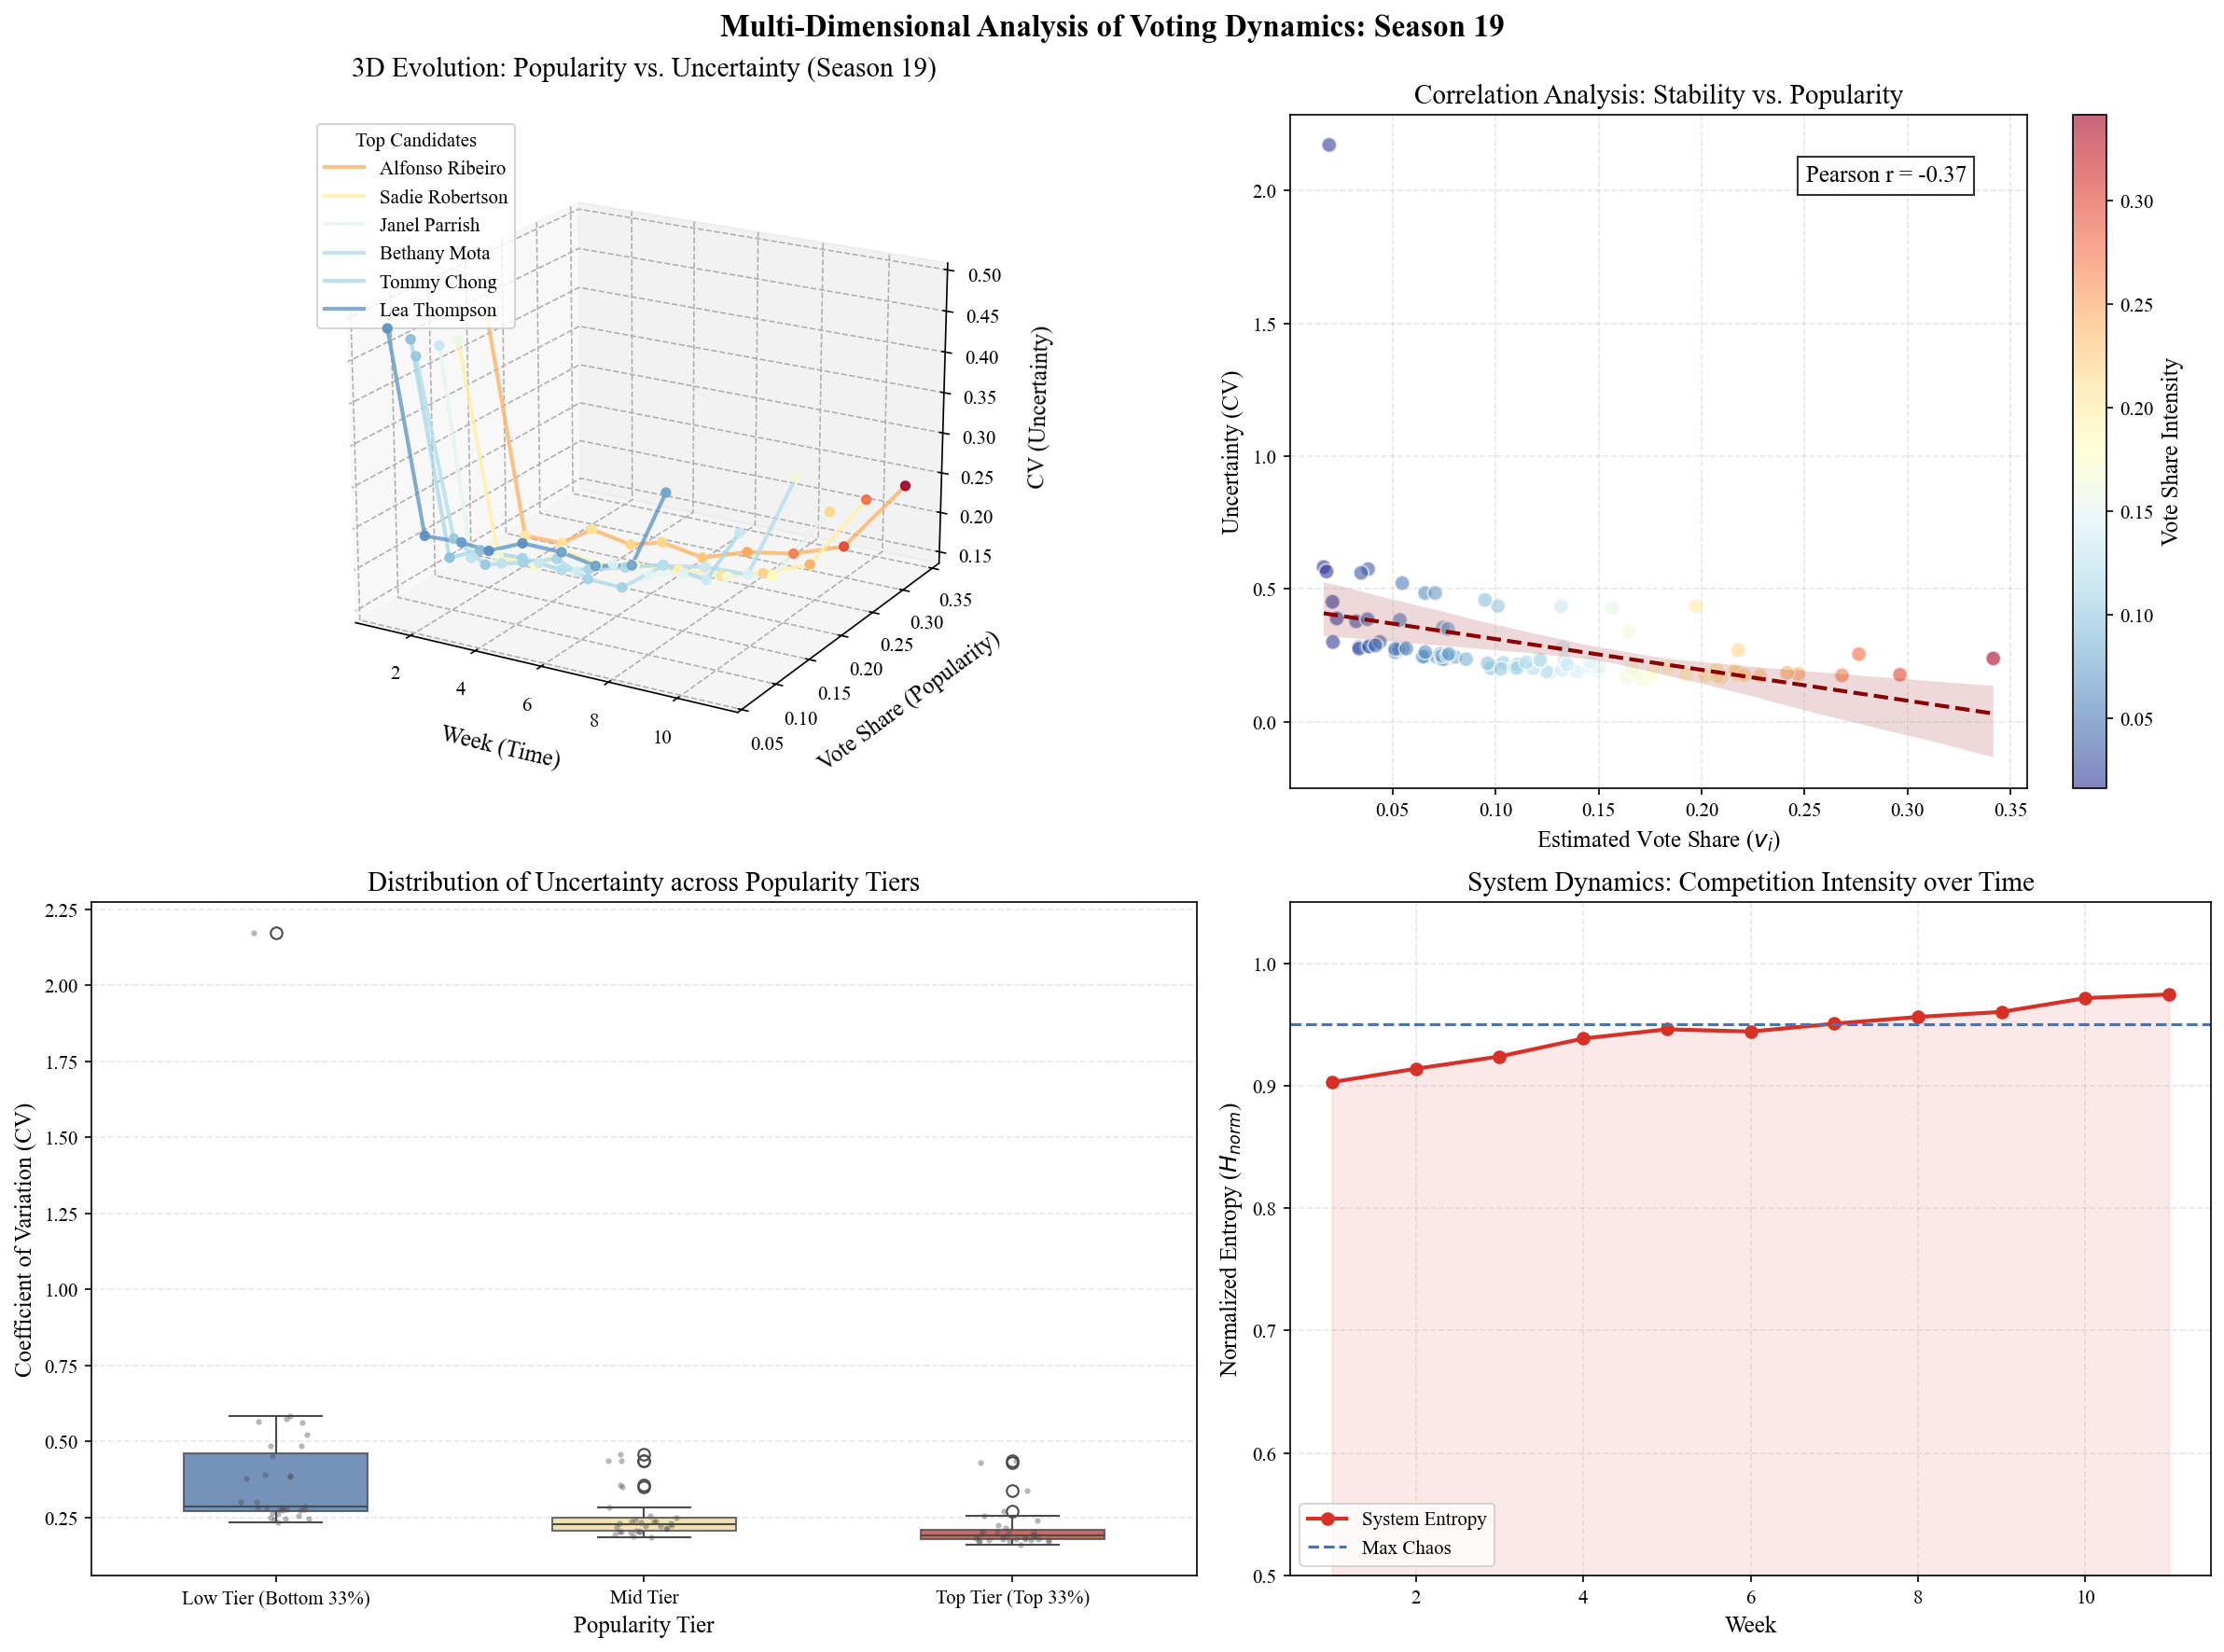

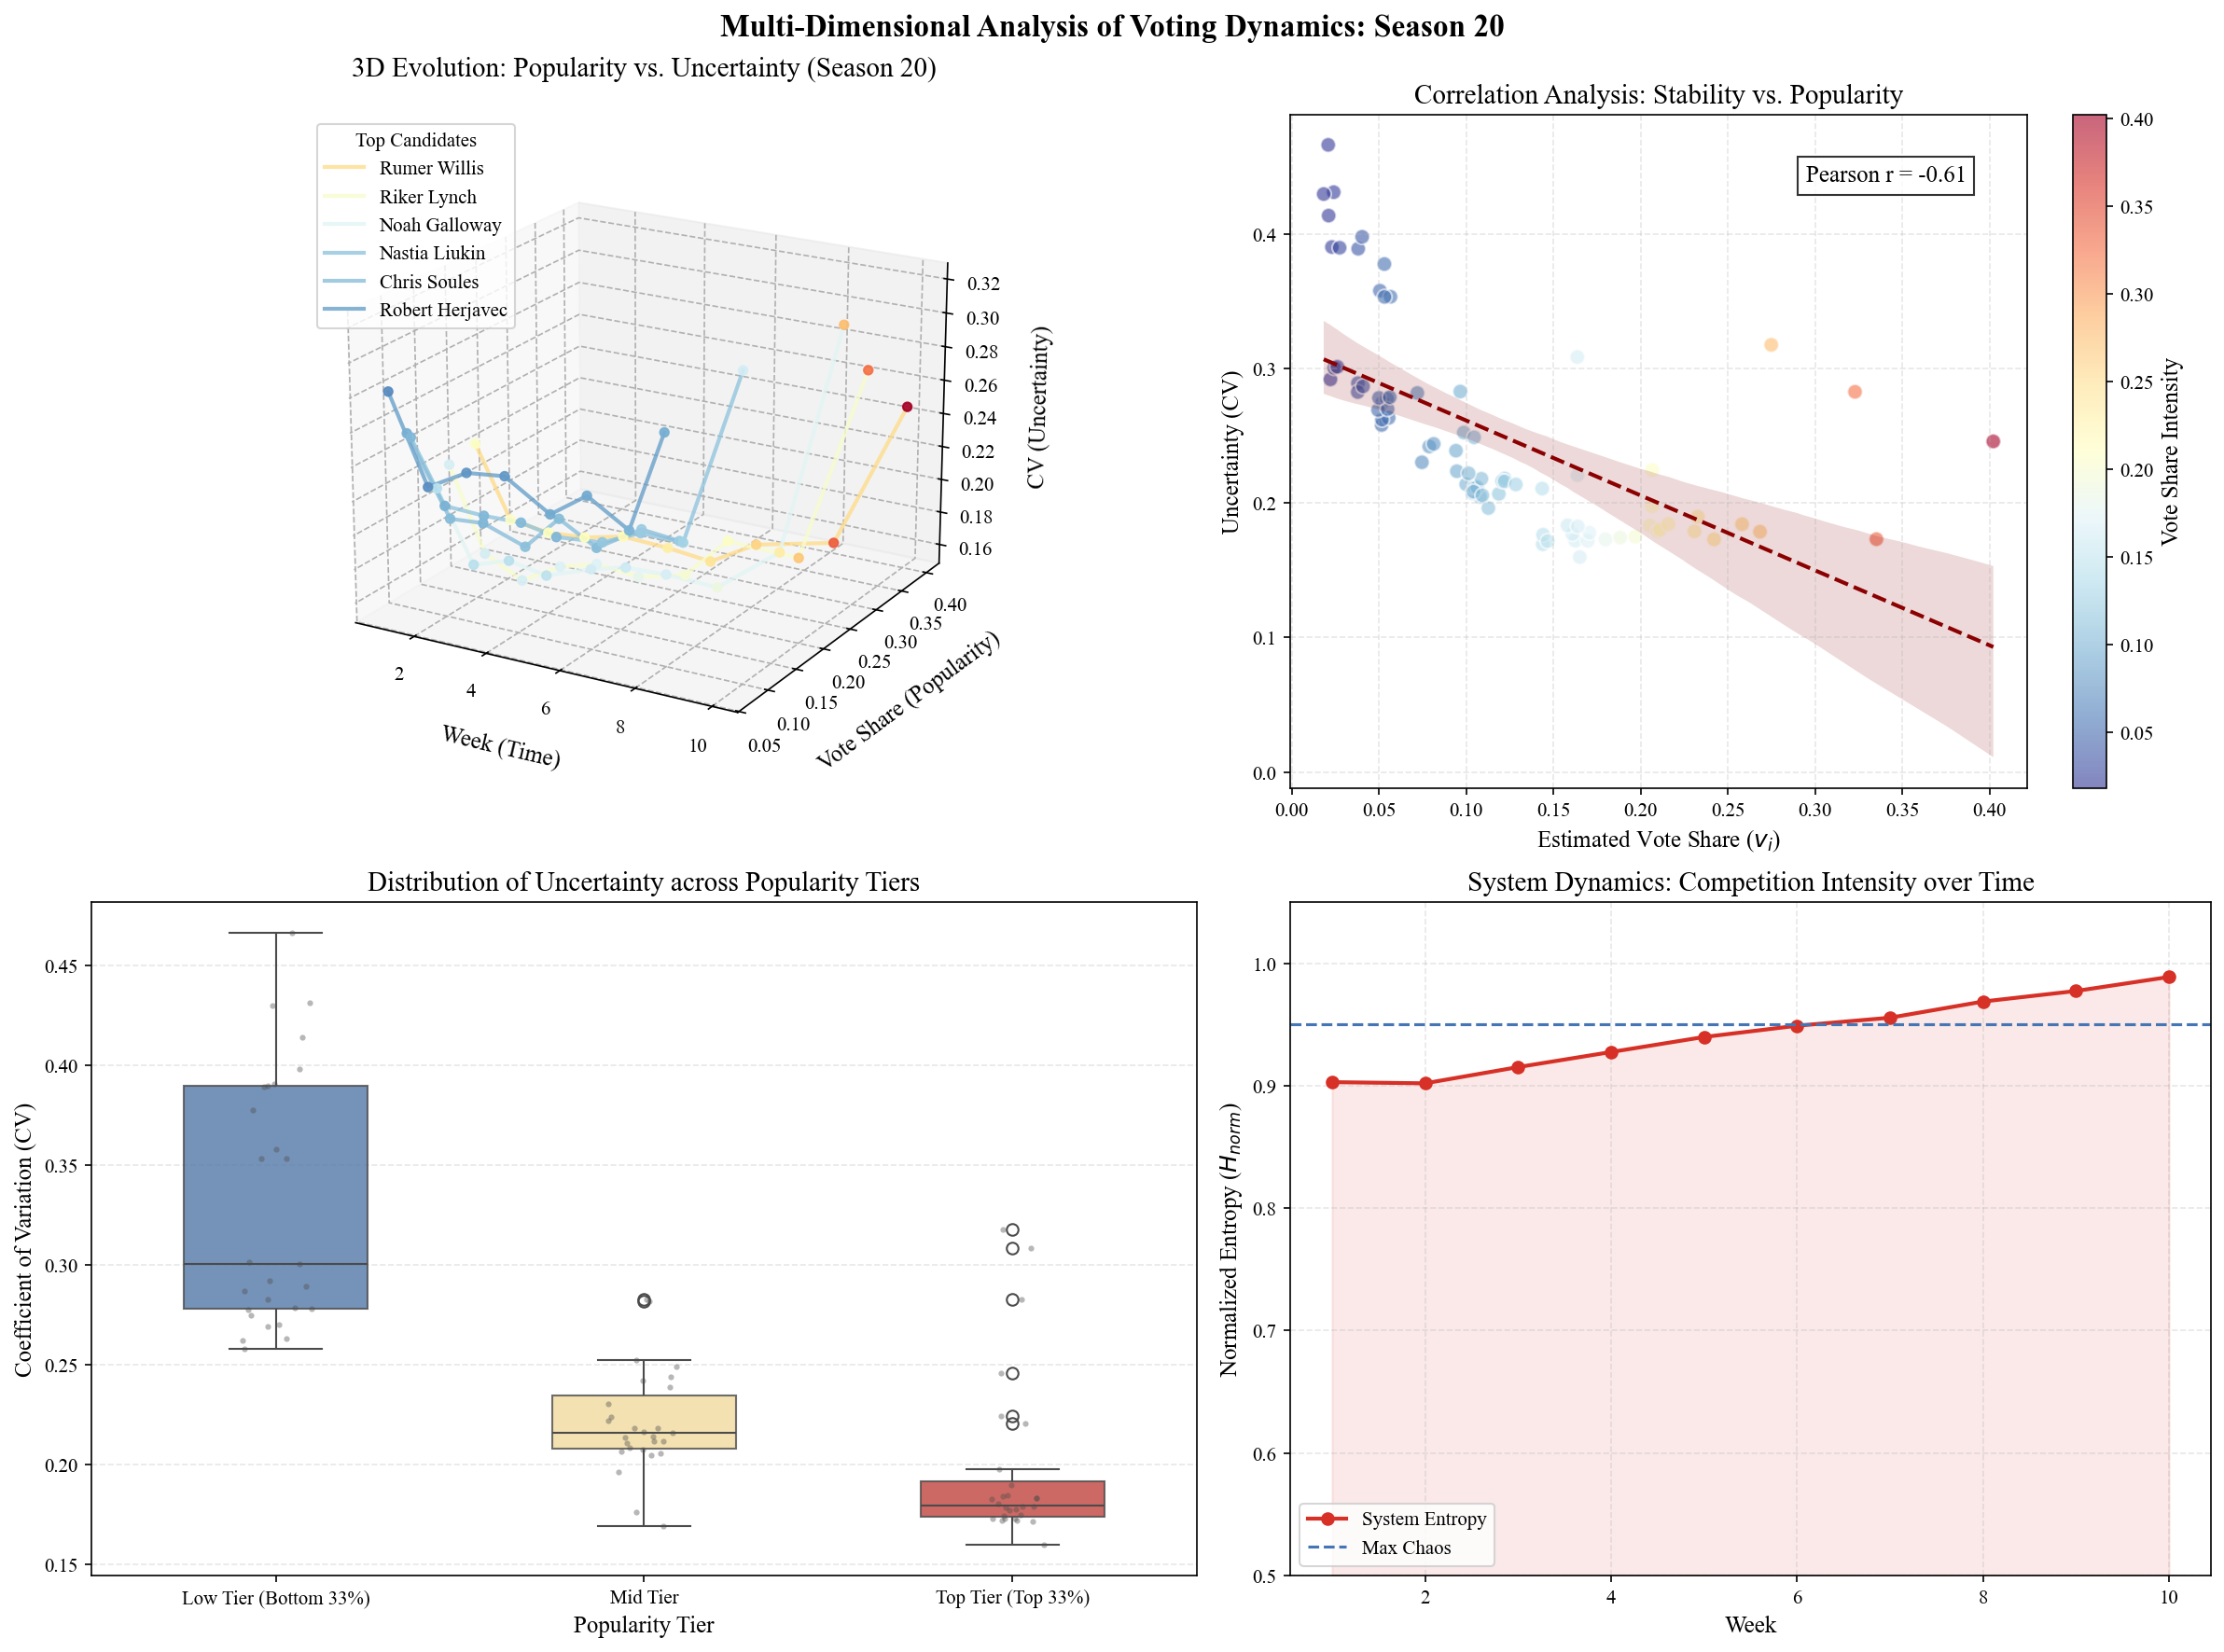

In [4]:
# ==============================================================================
# MCM High-Quality Visualization Module (Refined Style)
# ==============================================================================

def set_mcm_style():
    """设置符合 MCM 论文发表级别的绘图风格，匹配提供的图片样式"""
    plt.rcParams.update({
        "font.family": "serif",          # 衬线字体 (Times New Roman 风格)
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 150,               # 高分辨率
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "axes.facecolor": "white",       # 纯白背景
        "figure.facecolor": "white",
        "lines.linewidth": 1.5,
        "pdf.fonttype": 42               # 确保导出为矢量字
    })

def plot_advanced_mcm_visuals(viz_df, ent_df, target_season):
    set_mcm_style()
    
    # 筛选特定赛季数据
    s_df = viz_df[viz_df["season"] == target_season].copy()
    if s_df.empty:
        print(f"Season {target_season} data is empty.")
        return

    # 创建画布： 2x2 布局 (类似于提供的图片结构)
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1.2, 1])

    # ---------------------------------------------------------
    # Panel A: 3D Trajectory of Stability (左上)
    # ---------------------------------------------------------
    # 解释：展示选手的动态变化。X=周, Y=选票份额, Z=不确定性(CV)
    # 颜色：使用 Vote Share 映射到红蓝渐变 (Red=High Votes, Blue=Low Votes)
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    
    # 选出该赛季总票数前 6 名的选手进行展示，避免混乱
    top_candidates = s_df.groupby("celebrity_name")["votes_ens"].sum().nlargest(6).index
    
    # 获取红蓝渐变色谱
    cmap = plt.get_cmap("RdYlBu_r") # Red=High, Blue=Low
    norm = mcolors.Normalize(vmin=s_df["vote_share_ens"].min(), vmax=s_df["vote_share_ens"].max())

    for name in top_candidates:
        p_data = s_df[s_df["celebrity_name"] == name].sort_values("week")
        x = p_data["week"]
        y = p_data["vote_share_ens"]
        z = p_data["cv"] # Coefficient of Variation (Uncertainty)
        
        # 绘制线条
        # 技巧：分段绘制以实现线条渐变
        points = np.array([x, y, z]).T.reshape(-1, 1, 3)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # 使用 Line3DCollection 实现渐变
        # 这里为了简单和图例清晰，我们主要按平均热度给整条线着色，但在点上用散点表示具体热度
        avg_share = y.mean()
        line_color = cmap(norm(avg_share))
        
        ax1.plot(x, y, z, color=line_color, alpha=0.8, linewidth=2, label=name)
        ax1.scatter(x, y, z, c=y, cmap=cmap, norm=norm, s=20, alpha=0.9)

    ax1.set_xlabel("Week (Time)", labelpad=10)
    ax1.set_ylabel("Vote Share (Popularity)", labelpad=10)
    ax1.set_zlabel("CV (Uncertainty)", labelpad=10)
    ax1.set_title(f"3D Evolution: Popularity vs. Uncertainty (Season {target_season})", pad=20)
    ax1.view_init(elev=20, azim=-60)
    # 添加简化的图例
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), title="Top Candidates", frameon=True)

    # ---------------------------------------------------------
    # Panel B: Correlation: Uncertainty vs Vote Share (右上)
    # ---------------------------------------------------------
    # 对应图片右上角：散点图 + 回归线
    # 解释：验证假设——票数越高(越红)，不确定性(CV)越低。
    ax2 = fig.add_subplot(gs[0, 1])
    
    # 散点
    sc = ax2.scatter(
        s_df["vote_share_ens"], 
        s_df["cv"], 
        c=s_df["vote_share_ens"], 
        cmap="RdYlBu_r", 
        alpha=0.6, 
        edgecolor='w', 
        s=60
    )
    
    # 回归线
    sns.regplot(
        data=s_df, x="vote_share_ens", y="cv", 
        scatter=False, ax=ax2, color="darkred", 
        line_kws={"linewidth": 2, "linestyle": "--"},
        ci=95
    )
    
    # 添加统计文本 (R^2 等)
    corr = s_df[["vote_share_ens", "cv"]].corr().iloc[0, 1]
    ax2.text(0.7, 0.9, f"Pearson r = {corr:.2f}", transform=ax2.transAxes, 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax2.set_xlabel("Estimated Vote Share ($v_i$)")
    ax2.set_ylabel("Uncertainty (CV)")
    ax2.set_title("Correlation Analysis: Stability vs. Popularity")
    
    # 添加 Colorbar
    cbar = plt.colorbar(sc, ax=ax2)
    cbar.set_label("Vote Share Intensity")

    # ---------------------------------------------------------
    # Panel C: Box Plot of Uncertainty by Vote Tier (左下)
    # ---------------------------------------------------------
    # 对应图片左下角：分箱箱线图
    # 解释：将选手按票数分为 Low, Med, High 三组，展示其不确定性分布。
    ax3 = fig.add_subplot(gs[1, 0])
    
    # 创建分箱
    s_df["Tier"] = pd.qcut(s_df["vote_share_ens"], 3, labels=["Low Tier (Bottom 33%)", "Mid Tier", "Top Tier (Top 33%)"])
    
    # 自定义 Palette 匹配红蓝风格 (Blue -> Yellow -> Red)
    tier_pal = {"Low Tier (Bottom 33%)": "#4575b4", "Mid Tier": "#fee090", "Top Tier (Top 33%)": "#d73027"}
    
    sns.boxplot(
        data=s_df, x="Tier", y="cv", 
        palette=tier_pal, ax=ax3, width=0.5,
        boxprops=dict(alpha=.8)
    )
    sns.stripplot(data=s_df, x="Tier", y="cv", color=".3", alpha=0.4, size=3, ax=ax3)
    
    ax3.set_title("Distribution of Uncertainty across Popularity Tiers")
    ax3.set_xlabel("Popularity Tier")
    ax3.set_ylabel("Coefficient of Variation (CV)")
    
    # ---------------------------------------------------------
    # Panel D: Entropy (System Stability) Over Time (右下)
    # ---------------------------------------------------------
    # 对应图片左侧的 Line Plot 风格
    # 解释：系统熵值随时间变化。
    ax4 = fig.add_subplot(gs[1, 1])
    
    season_ent = ent_df[ent_df["season"] == target_season]
    
    # 绘制带填充的线图
    ax4.plot(season_ent["week"], season_ent["normalized_entropy"], 
             color="#d73027", marker='o', linewidth=2, label="System Entropy")
    ax4.fill_between(season_ent["week"], 0.5, season_ent["normalized_entropy"], 
                     color="#d73027", alpha=0.1)
    
    # 阈值线
    ax4.axhline(y=0.95, color="#4575b4", linestyle="--", label="Max Chaos")
    
    ax4.set_ylim(0.5, 1.05)
    ax4.set_xlabel("Week")
    ax4.set_ylabel("Normalized Entropy ($H_{norm}$)")
    ax4.set_title("System Dynamics: Competition Intensity over Time")
    ax4.legend(loc="lower left")
    
    # 整体调整
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    fig.suptitle(f"Multi-Dimensional Analysis of Voting Dynamics: Season {target_season}", fontsize=16, weight='bold')
    
    plt.show()

# --------------------------
# 运行可视化 (以 Season 19 为例，数据较丰富)
# --------------------------
# 注意：需要 Cell 2 运行成功后生成的 viz_df 和 ent_df
if 'viz_df' in globals() and 'ent_df' in globals():
    plot_advanced_mcm_visuals(viz_df, ent_df, target_season=19)
    plot_advanced_mcm_visuals(viz_df, ent_df, target_season=20)
else:
    print("请先运行 Cell 2 生成数据！")


### 文件导出

In [5]:
# ==============================================================================
# [Export Data] 核心导出部分 (完全保留原逻辑)
# ==============================================================================
# 依赖变量: final_ens (DataFrame), all_unc (List of DataFrames) - 来自 Cell 2

print("\n--- 正在导出 Task 1 粉丝投票数据 ---")

try:
    # 检查 Cell 2 是否成功运行并生成了必要变量
    if 'final_ens' not in globals() or 'all_unc' not in globals():
        raise ValueError("缺少必要数据变量 (final_ens 或 all_unc)。请先运行 Cell 2。")

    # 整合不确定性数据
    if len(all_unc) > 0:
        # 这里重新 concat 一次以确保逻辑独立性，完全复刻原代码行为
        final_unc_export = pd.concat(all_unc)
        # 合并
        df_export = pd.merge(
            final_ens, 
            final_unc_export, 
            on=["season", "week", "celebrity_name"], 
            how="left"
        )
    else:
        df_export = final_ens.copy()
        print("Warning: 未找到不确定性数据，仅导出估算值。")

    # 筛选列 (保持原代码定义)
    target_cols = [
        "season", "week", "celebrity_name",
        "votes_ens",         # 估算票数
        "vote_share_ens",    # 估算份额
        "vote_share_A",      # 模型 A 份额
        "vote_share_B",      # 模型 B 份额
        "mean_share",        # 贝叶斯均值
        "low_share",         # 5% 下界
        "high_share",        # 95% 上界
        "cv"                 # 变异系数
    ]
    
    # 仅保留存在的列
    export_cols = [c for c in target_cols if c in df_export.columns]
    df_export = df_export[export_cols]

    # 排序 (保持原代码定义: Season asc, Week asc, Votes desc)
    df_export = df_export.sort_values(by=["season", "week", "votes_ens"], ascending=[True, True, False])
    
    # 保存
    output_csv = "task1_fan_votes_estimated.csv"
    df_export.to_csv(output_csv, index=False)
    
    print(f"✅ 成功! 文件已保存为: {output_csv}")
    print(f"   文件位置: {pd.Timestamp.now()}")
    print(f"   数据行数: {len(df_export)}")
    
except Exception as e:
    import traceback
    print(f"❌ 导出过程中发生错误: {e}")
    print(traceback.format_exc())

print("\nTask 1 全部运行完成。")



--- 正在导出 Task 1 粉丝投票数据 ---
✅ 成功! 文件已保存为: task1_fan_votes_estimated.csv
   文件位置: 2026-02-01 15:41:14.058056
   数据行数: 2777

Task 1 全部运行完成。


## Task1绘图模块2

开始批量绘制: [2, 21, 30]
风格: MCM High-Quality (Red/Blue Gradient)
--> Plotting Season 2...


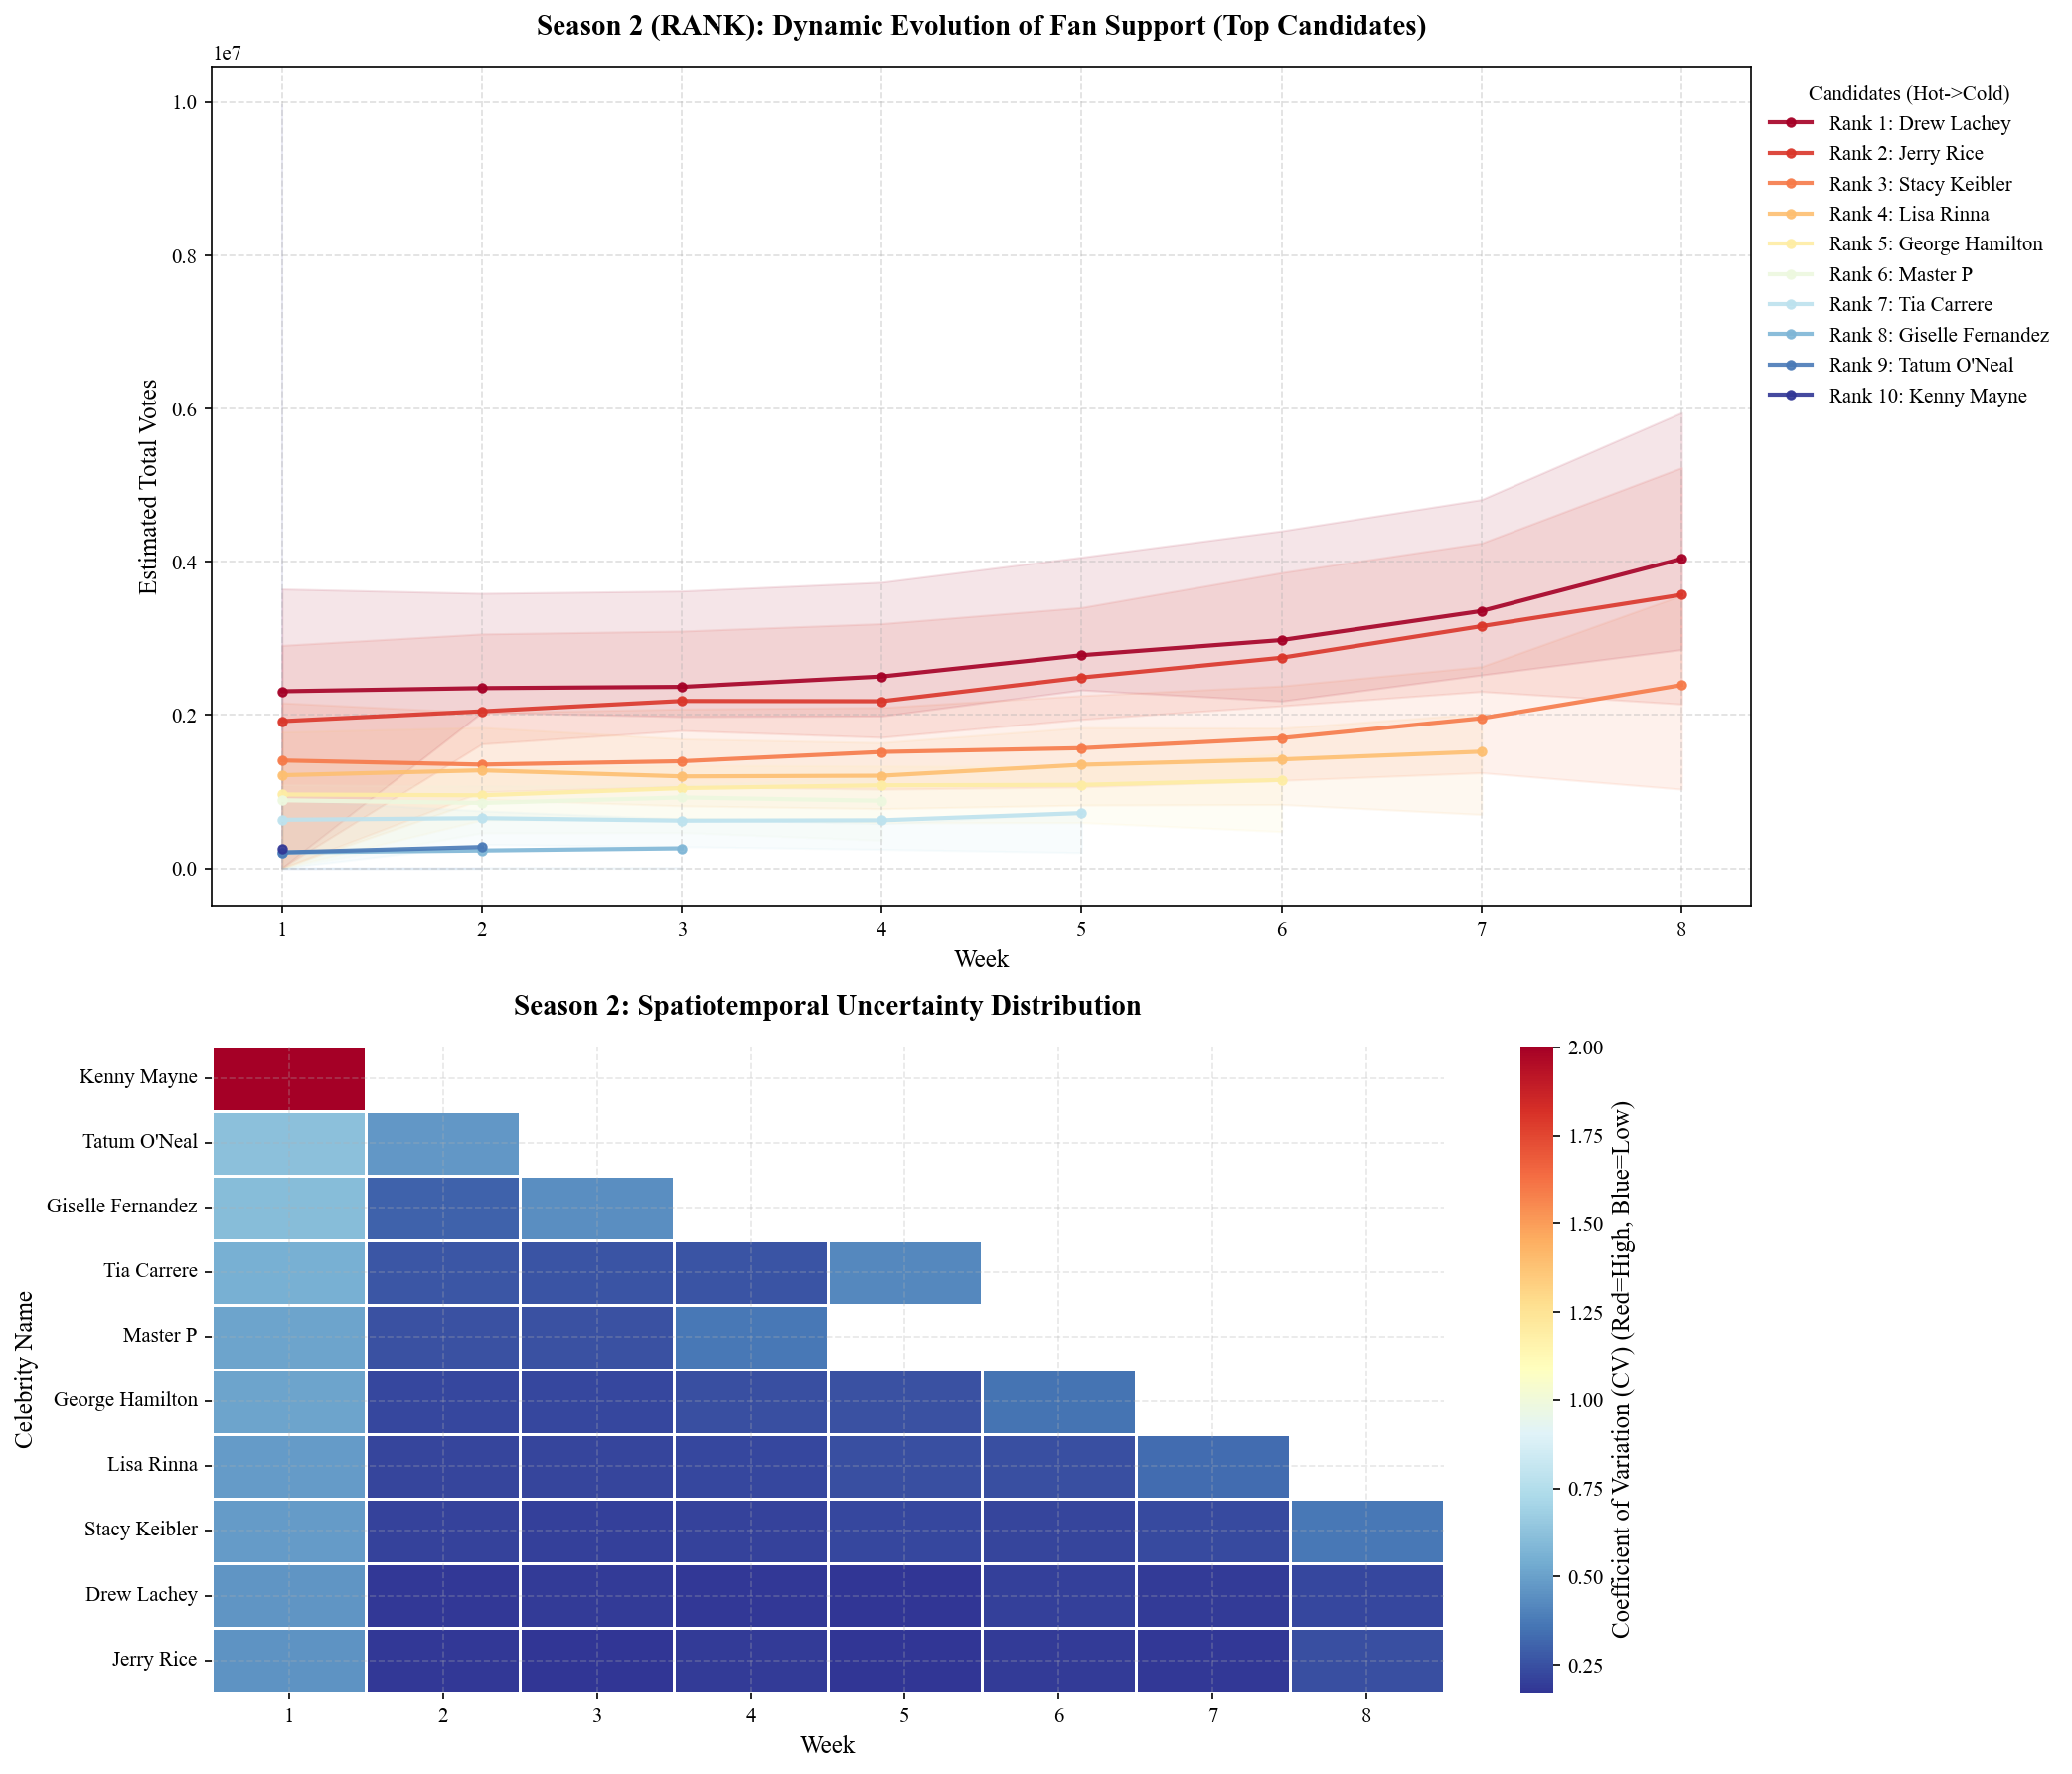

--> Plotting Season 21...


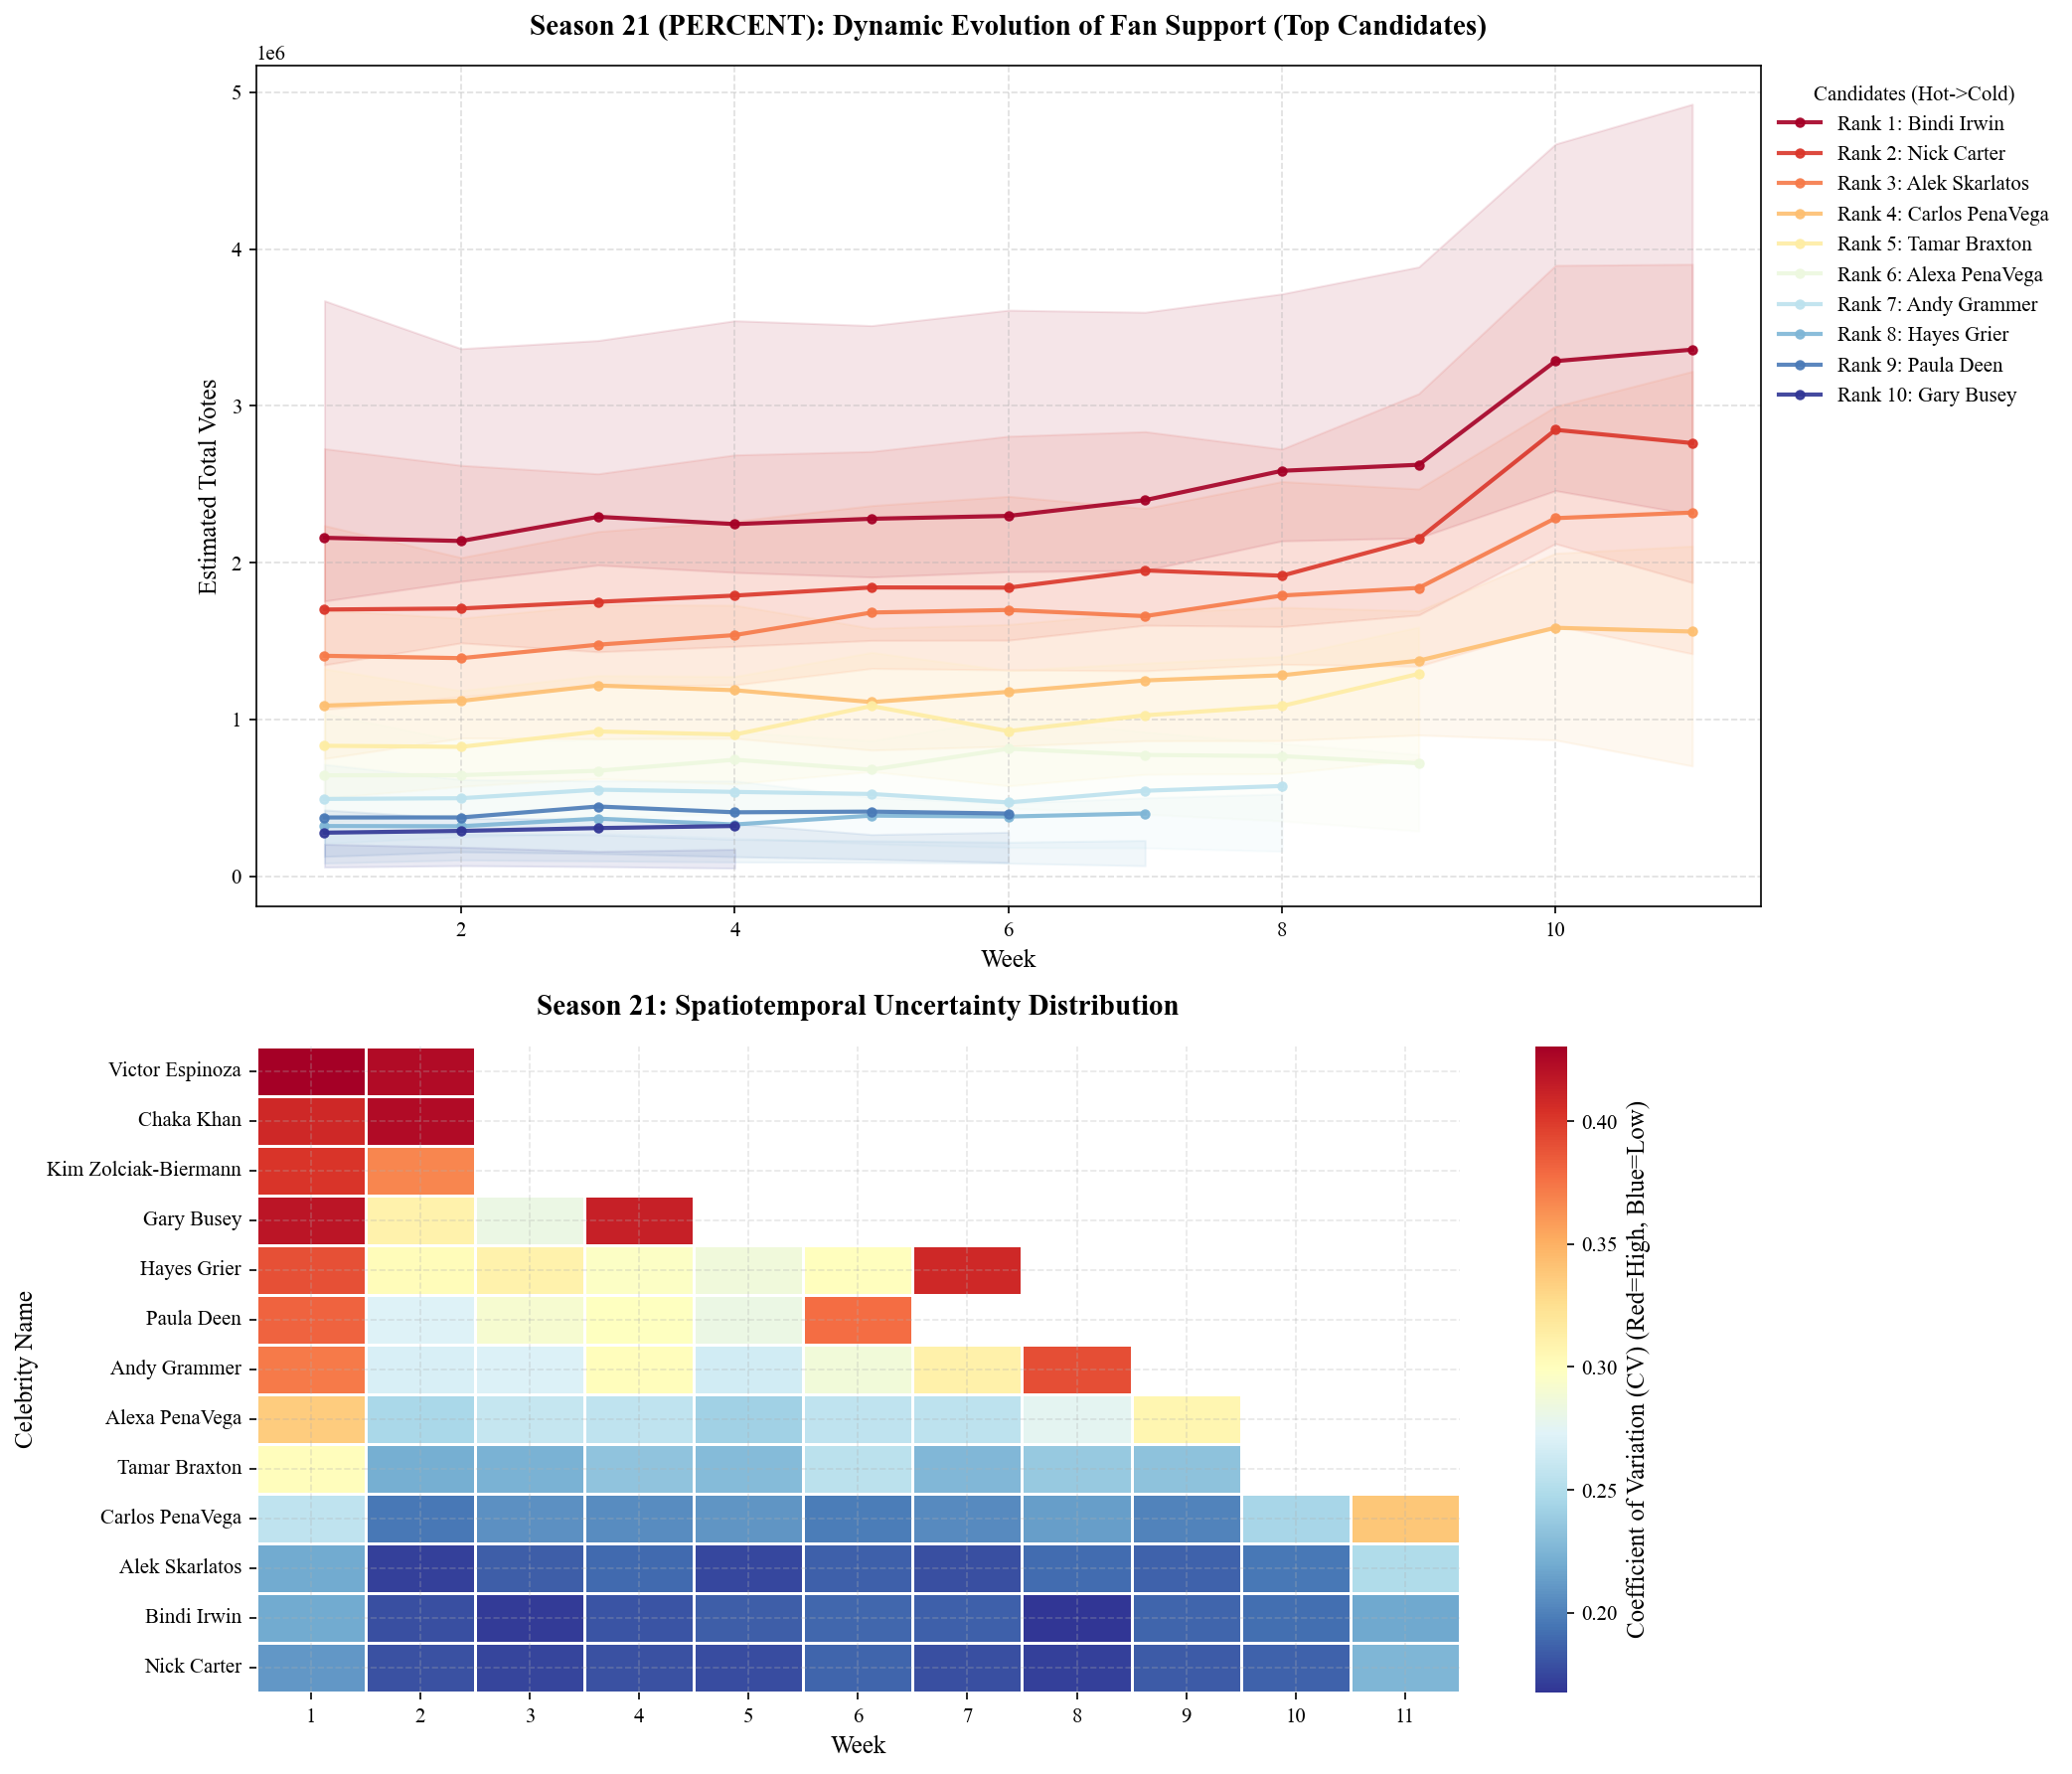

--> Plotting Season 30...


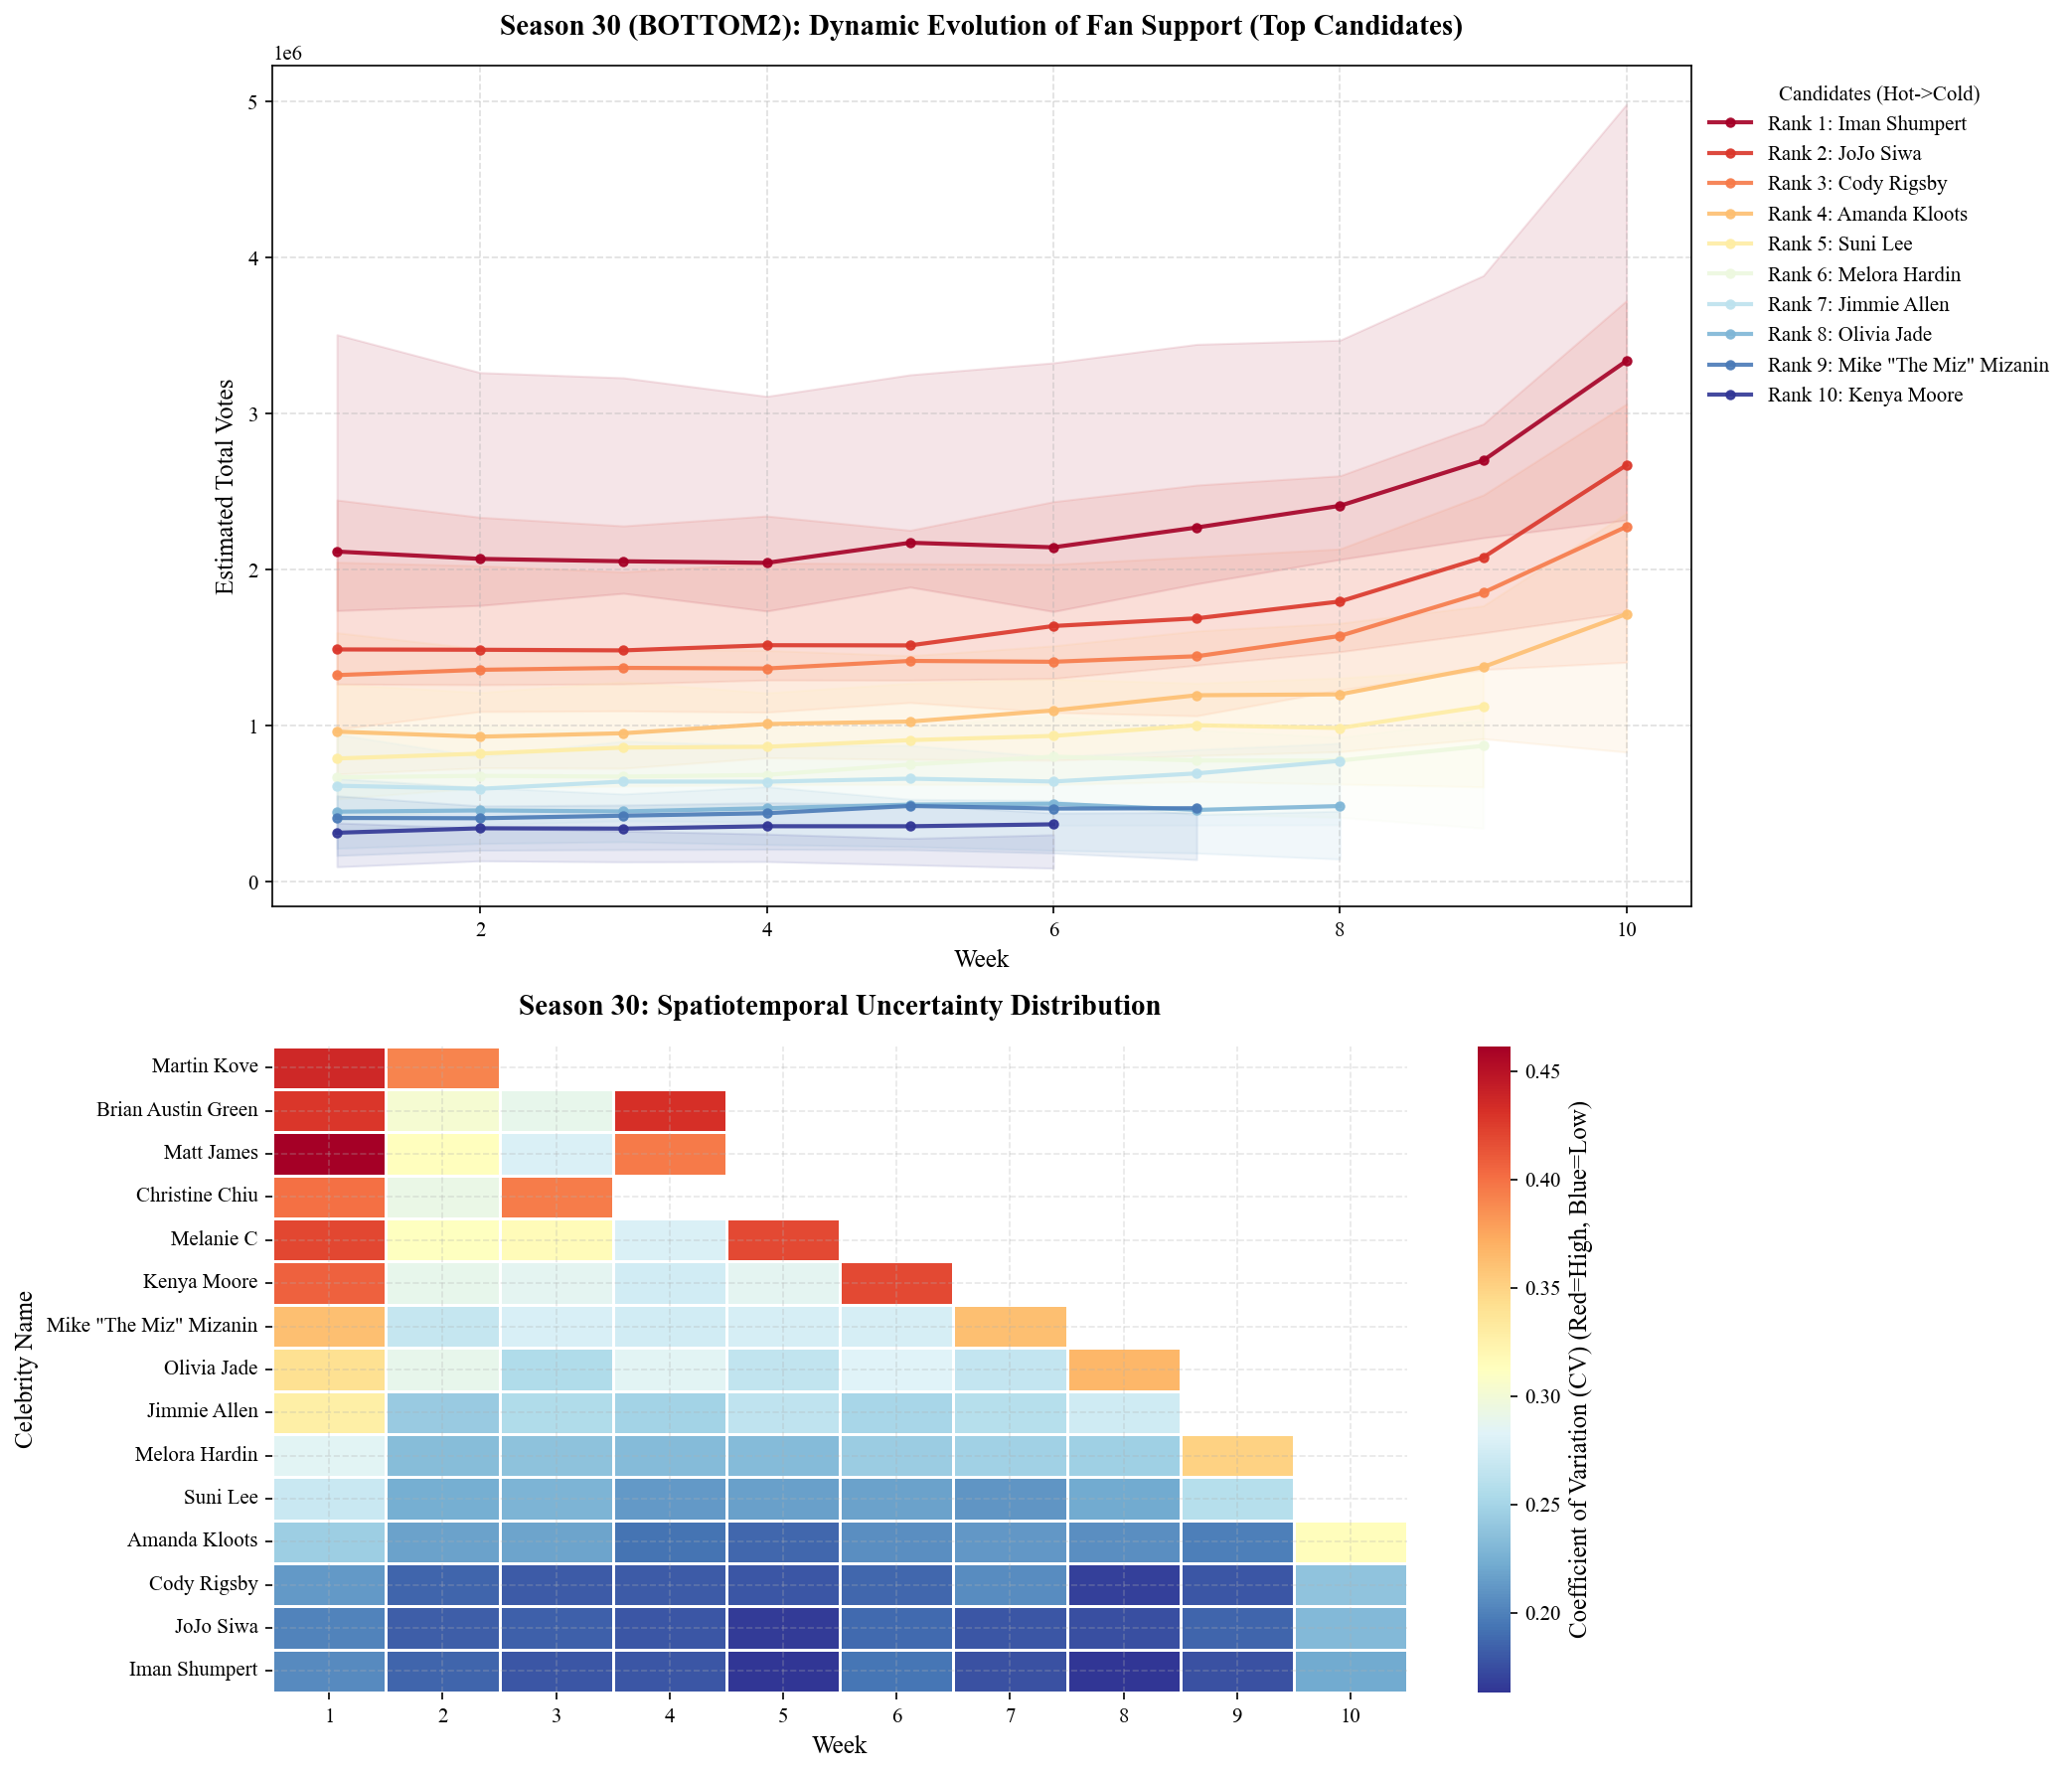

In [6]:
# ==============================================================================
# Fix & Plot: Redefining plot_season_analysis with MCM Red/Blue Style
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

# 1. 重新定义函数名，以匹配您代码中的调用习惯
#    参数保持原签名: season, df_ens, df_unc, events
def plot_season_analysis(season, df_ens, df_unc, events):
    """
    Re-implementation of the original plotting function but with 
    High-Quality MCM Red/Blue Gradient Styling.
    """
    
    # --- 样式设置 ---
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 150,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "axes.facecolor": "white",
        "lines.linewidth": 2
    })
    
    # --- 数据准备 ---
    # 如果传入的 df_ens 已经是合并后的 viz_df，直接使用；否则合并
    # 这里做个兼容处理
    if "cv" not in df_ens.columns and not df_unc.empty:
        # 尝试合并 (简单做法)
        s_df = pd.merge(df_ens[df_ens["season"]==season], 
                       df_unc[df_unc["season"]==season], 
                       on=["season", "week", "celebrity_name"], how="left")
    else:
        s_df = df_ens[df_ens["season"] == season].copy()
        
    if s_df.empty:
        print(f"Skipping Season {season}: Data is empty.")
        return

    # 获取规则名称
    rule = "UNKNOWN"
    for (s, w), ev in events.items():
        if s == season:
            rule = ev.rule
            break

    # --- 创建画布 (上下两图: 折线 + 热力) ---
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1.3, 1]})
    
    # =========================================================
    # Subplot 1: Estimated Vote Trajectories (红蓝渐变折线)
    # =========================================================
    ax1 = axes[0]
    
    # 筛选 Top 8 选手 (避免线条过多杂乱)
    # 按总票数排序
    totals = s_df.groupby("celebrity_name")["votes_ens"].sum().sort_values(ascending=False)
    top_candidates = totals.index[:10] # 展示前10名
    
    # 生成渐变色谱 (RdYlBu)
    # 排名高的(索引0) -> 红色(Hot)，排名低的 -> 蓝色(Cold)
    # 使用 matplotlib 的 colormap
    cmap = plt.get_cmap("RdYlBu")
    colors = [cmap(i) for i in np.linspace(0, 1, len(top_candidates))]
    
    for i, name in enumerate(top_candidates):
        d = s_df[s_df["celebrity_name"] == name].sort_values("week")
        weeks = d["week"].values
        v_mean = d["votes_ens"].values
        
        # 尝试获取置信区间列 (兼容不同列名)
        if "high_share" in d.columns:
            # Cell 2 的数据 high_share 是比例，需要转为票数
            # 注意：全局常量 TOTAL_VOTES 需要在上下文中存在
            v_high = d["high_share"].values * 10_000_000 
            v_low = d["low_share"].values * 10_000_000
        elif "votes_ens" in d.columns:
            # 如果没有区间数据，就画一条简单的带
            v_high = v_mean * 1.05
            v_low = v_mean * 0.95
        else:
            v_high = v_mean
            v_low = v_mean

        # 绘制
        ax1.plot(weeks, v_mean, label=f"Rank {i+1}: {name}", color=colors[i], marker='o', markersize=4, alpha=0.9)
        ax1.fill_between(weeks, v_low, v_high, color=colors[i], alpha=0.1) 
    
    ax1.set_title(f"Season {season} ({rule}): Dynamic Evolution of Fan Support (Top Candidates)", fontweight='bold', pad=15)
    ax1.set_ylabel("Estimated Total Votes")
    ax1.set_xlabel("Week")
    # 图例放外侧防止遮挡
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Candidates (Hot->Cold)", frameon=False)
    ax1.grid(True, linestyle='--', alpha=0.4)

    # =========================================================
    # Subplot 2: Uncertainty Heatmap (红蓝渐变热力)
    # =========================================================
    ax2 = axes[1]
    
    # 准备 Heatmap 数据
    if "cv" in s_df.columns:
        val_col = "cv"
        label = "Coefficient of Variation (CV)"
    elif "std_share" in s_df.columns:
        val_col = "std_share"
        label = "Standard Deviation"
    else:
        val_col = "votes_ens" # Fallback
        label = "Votes"

    heatmap_data = s_df.pivot(index="celebrity_name", columns="week", values=val_col)
    
    # 排序：按平均值排序，把最不稳定的(数值大的)放上面
    mean_val = heatmap_data.mean(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.reindex(mean_val.index)
    
    # 绘图: RdYlBu_r (Red=High/Unstable, Blue=Low/Stable)
    sns.heatmap(
        heatmap_data, 
        ax=ax2, 
        cmap="RdYlBu_r", 
        cbar_kws={'label': f'{label} (Red=High, Blue=Low)'},
        linewidths=0.5,
        linecolor='white'
    )
    
    ax2.set_title(f"Season {season}: Spatiotemporal Uncertainty Distribution", fontweight='bold', pad=15)
    ax2.set_xlabel("Week")
    ax2.set_ylabel("Celebrity Name")
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 2. 执行批量绘图
# ---------------------------------------------------------
target_seasons_to_plot = [2, 21, 30]

print(f"========================================")
print(f"开始批量绘制: {target_seasons_to_plot}")
print(f"风格: MCM High-Quality (Red/Blue Gradient)")
print(f"========================================")

# 确保 viz_df 存在 (来自 Cell 2)
if 'viz_df' in globals() and not viz_df.empty:
    for s in target_seasons_to_plot:
        try:
            print(f"--> Plotting Season {s}...")
            # 调用刚刚定义的函数
            # 注意：我们将 viz_df 同时传给 df_ens 和 df_unc 参数，因为 viz_df 已经包含了所有列
            plot_season_analysis(s, viz_df, viz_df, events)
        except Exception as e:
            print(f"❌ 绘制 Season {s} 时出错: {e}")
            import traceback
            traceback.print_exc()
else:
    print("❌ 错误: 内存中未找到数据 (viz_df)。请先运行 Cell 2 生成数据！")


# Task2

In [7]:
# ==============================================================================
# [Task 2] 独立仿真模块 (Logic Core)
# ==============================================================================

import pandas as pd
import numpy as np
from scipy.stats import rankdata, spearmanr
from collections import defaultdict
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

class Task2Simulator:
    def __init__(self, events_dict, vote_df):
        """
        events_dict: Task 1 的 events 字典 {(season, week): WeekEvent}
        vote_df: Task 1 输出的 final_ens DataFrame
        """
        self.events = events_dict
        self.vote_df = vote_df
        self.simulation_results = []
        
        # 1. 预计算每一季的决赛周（最大周数）
        season_weeks = defaultdict(list)
        for (s, w) in self.events.keys():
            season_weeks[s].append(w)
        self.season_max_week = {s: max(weeks) for s, weeks in season_weeks.items()}
        
        # 2. 维护每一季的“实际已淘汰名单”历史
        self.eliminated_history = defaultdict(list)

    def _get_fan_shares(self, season, week, active_names):
        sub = self.vote_df[(self.vote_df["season"] == season) & (self.vote_df["week"] == week)]
        if sub.empty:
            return np.ones(len(active_names)) / len(active_names)
        name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
        shares = np.array([name_map.get(n, 0.0) for n in active_names])
        if shares.sum() > 0: shares = shares / shares.sum()
        return shares

    def _calculate_rank_order(self, j_scores, fan_shares, active_names):
        """计算在场选手的 Rank 顺序 (1st ... Last)"""
        j_rank = rankdata(-j_scores, method='min')
        f_rank = rankdata(-fan_shares, method='min')
        total_rank = j_rank + f_rank
        
        candidates = []
        for i, name in enumerate(active_names):
            candidates.append({
                'name': name,
                'score': total_rank[i],    # 越小越好
                'tie_break': fan_shares[i] # 越大越好
            })
        candidates.sort(key=lambda x: x['tie_break'], reverse=True) 
        candidates.sort(key=lambda x: x['score'], reverse=False)
        return [c['name'] for c in candidates]

    def _calculate_percent_order(self, j_scores, fan_shares, active_names):
        """计算在场选手的 Percent 顺序 (1st ... Last)"""
        total_j = j_scores.sum()
        j_pct = j_scores / total_j if total_j > 0 else np.zeros_like(j_scores)
        total_pct = j_pct + fan_shares
        
        candidates = []
        for i, name in enumerate(active_names):
            candidates.append({
                'name': name,
                'score': total_pct[i] # 越大越好
            })
        candidates.sort(key=lambda x: x['score'], reverse=True)
        return [c['name'] for c in candidates]

    def run(self):
        sorted_keys = sorted(self.events.keys())
        self.eliminated_history = defaultdict(list)
        
        for (s, w) in sorted_keys:
            ev = self.events[(s, w)]
            is_final_week = (w == self.season_max_week[s])
            
            if is_final_week:
                k_elim_processed = 0
                actual_elim_display = [] 
                week_type = 'Final'
            else:
                k_elim_processed = ev.k_elim
                actual_elim_display = ev.eliminated
                week_type = 'Elimination' if k_elim_processed > 0 else 'Non-Elim'
            
            active_names = ev.active_names
            fan_shares = self._get_fan_shares(s, w, active_names)
            
            # 4. 计算【在场选手】相对排名
            active_rank_order = self._calculate_rank_order(ev.j_scores, fan_shares, active_names)
            active_pct_order = self._calculate_percent_order(ev.j_scores, fan_shares, active_names)
            
            # 5. 构建【全员排名】
            # 历史回放：我们需要 [在场] + [刚淘汰(好->差)] + [早淘汰]
            # 这里 eliminated_history 存储顺序应为：[Week1淘汰, Week2差, Week2好, ...]
            # 逆序后变成：[Week2好, Week2差, Week1淘汰]
            past_eliminated_reversed = self.eliminated_history[s][::-1]
            full_rank_order = active_rank_order + past_eliminated_reversed
            full_pct_order = active_pct_order + past_eliminated_reversed
            
            # 6. 提取仿真数据
            is_rank_identical = (full_rank_order == full_pct_order)
            sim_rank_elim, sim_pct_elim = [], []
            is_elim_diff = False
            
            if k_elim_processed > 0:
                sim_rank_elim = active_rank_order[-k_elim_processed:] 
                sim_pct_elim = active_pct_order[-k_elim_processed:]
                is_elim_diff = (set(sim_rank_elim) != set(sim_pct_elim))
            
            sim_rank_winner = full_rank_order[0]
            sim_pct_winner = full_pct_order[0]
            is_winner_diff = (sim_rank_winner != sim_pct_winner)
            
            # --- [核心修复] 更新历史记录时的排序逻辑 ---
            if not is_final_week and ev.eliminated:
                # 1. 获取 (Name, Placement) 对
                elim_batch = []
                for name in ev.eliminated:
                    if name in ev.active_names:
                        idx = ev.active_names.index(name)
                        place = ev.placements[idx]
                        elim_batch.append((name, place))
                
                # 2. 排序逻辑：
                # 我们希望加入列表的顺序是 [第10名, 第9名]。
                # 这样被 [::-1] 逆序后，变成 [第9名, 第10名]，紧接在 active_names 后面。
                # Placement 数值：10 > 9。
                # 所以我们要按 Placement 降序排列 (Desc)。
                elim_batch.sort(key=lambda x: x[1], reverse=True)
                
                sorted_names = [x[0] for x in elim_batch]
                self.eliminated_history[s].extend(sorted_names)
            
            # 10. 记录
            self.simulation_results.append({
                'season': s, 'week': w, 'type': week_type,
                'k_elim': k_elim_processed,
                'is_rank_identical': is_rank_identical,
                'actual_elim': actual_elim_display,
                'sim_rank_elim': sim_rank_elim, 'sim_pct_elim': sim_pct_elim,
                'is_elim_diff': is_elim_diff,
                'sim_rank_winner': sim_rank_winner, 'sim_pct_winner': sim_pct_winner,
                'is_winner_diff': is_winner_diff,
                'full_rank_order': ",".join(full_rank_order),
                'full_pct_order': ",".join(full_pct_order)
            })
            
        return pd.DataFrame(self.simulation_results)

# --- 辅助函数：深度验证 ---
def verify_full_ranking(original_data_path, simulation_result_path):
    print(f"\n{'='*20} 深度模型验证：S1-S27 全员排名对比 {'='*20}")
    
    # 1. 读取数据
    try:
        raw_df = pd.read_csv(original_data_path)
        sim_df = pd.read_csv(simulation_result_path)
    except FileNotFoundError:
        print("错误：找不到原始数据或仿真结果文件。")
        return

    finals_sim = sim_df[sim_df['type'] == 'Final'].copy()
    
    validation_log = []
    
    # S1-S27: 原始规则区间
    for season in range(1, 28):
        # --- A. 获取真实全员排名 (Ground Truth) ---
        season_raw = raw_df[raw_df['season'] == season]
        
        # 提取有 placement 的人，按名次升序 (1, 2, 3...)
        actual_df = season_raw.dropna(subset=['placement']).sort_values('placement')
        actual_list = actual_df['celebrity_name'].tolist()
        
        # --- B. 获取仿真全员排名 (Simulation) ---
        if season not in finals_sim['season'].values:
            continue
        sim_row = finals_sim[finals_sim['season'] == season].iloc[0]
        
        # 根据赛季选择对应的规则列
        if season <= 2:
            rule = "Rank"
            sim_list_str = sim_row['full_rank_order']
        else:
            rule = "Percent"
            sim_list_str = sim_row['full_pct_order']
            
        sim_list = sim_list_str.split(',')
        
        # --- C. 对齐名单 ---
        sim_filtered = [name for name in sim_list if name in actual_list]
        actual_filtered = [name for name in actual_list if name in sim_list]
        
        # --- D. 严格对比 ---
        is_exact_match = (actual_filtered == sim_filtered)
        
        mismatch_info = ""
        if not is_exact_match:
            for i, (act, sim) in enumerate(zip(actual_filtered, sim_filtered)):
                if act != sim:
                    mismatch_info = f"Pos {i+1}: Actual={act} vs Sim={sim}"
                    break
        
        validation_log.append({
            'Season': season,
            'Rule': rule,
            'Is_Perfect_Match': "✅" if is_exact_match else "❌",
            'Mismatch_Detail': mismatch_info
        })

    # --- 输出 ---
    val_df = pd.DataFrame(validation_log)
    perfect_count = len(val_df[val_df['Is_Perfect_Match']=='✅'])
    total = len(val_df)
    print(f"\n[验证摘要] 完全匹配赛季: {perfect_count} / {total} ({perfect_count/total:.1%})")
    if perfect_count < total:
        print("\n[差异详情]")
        print(val_df[val_df['Is_Perfect_Match']=='❌'][['Season', 'Mismatch_Detail']])
    else:
        print("\n[完美!] S1-S27 所有排位完全一致。")
    
    val_df.to_csv("task2_validation_full_rank.csv", index=False)

# --- 辅助函数：相关系数计算 ---
def generate_fan_rank_column(row, df_estimates):
    s, w = row['season'], row['week']
    sub = df_estimates[(df_estimates["season"] == s) & (df_estimates["week"] == w)]
    if sub.empty: return None
    
    try:
        if pd.isna(row['full_rank_order']): return None
        active_names = row['full_rank_order'].split(',')
        active_names = [n.strip() for n in active_names if n.strip()]
    except: return None
        
    name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
    contestant_votes = []
    for name in active_names:
        votes = name_map.get(name, -1) 
        contestant_votes.append((name, votes))
    
    # 按票数降序排列 (票高的 Rank 1)
    contestant_votes.sort(key=lambda x: x[1], reverse=True)
    sorted_names = [item[0] for item in contestant_votes]
    return ",".join(sorted_names)

def calculate_list_correlation(list_a_str, list_b_str):
    if pd.isna(list_a_str) or pd.isna(list_b_str): return None
    list_a = [n.strip() for n in list_a_str.split(',') if n.strip()]
    list_b = [n.strip() for n in list_b_str.split(',') if n.strip()]
    if len(list_a) != len(list_b) or len(list_a) < 2: return None
    
    rank_map_a = {name: idx for idx, name in enumerate(list_a)}
    rank_map_b = {name: idx for idx, name in enumerate(list_b)}
    
    vector_a, vector_b = [], []
    for name in list_a:
        if name in rank_map_b:
            vector_a.append(rank_map_a[name])
            vector_b.append(rank_map_b[name])
            
    if len(vector_a) < 2: return None
    rho, _ = spearmanr(vector_a, vector_b)
    return rho

# --- 执行入口 ---
if __name__ == "__main__":
    if 'events' in globals() and 'final_ens' in globals():
        print("\n" + "="*50)
        print("STARTING TASK 2 SIMULATION (Fix: No Elim in Finals)")
        print("="*50)

        # 运行
        task2_sim = Task2Simulator(events, final_ens)
        df_task2 = task2_sim.run()
        output_file = "task2_simulation_results_v3.csv" 
        df_task2.to_csv(output_file, index=False)
        print(f"Task 2 仿真完成! 结果已保存至: {output_file}")

        # 验证
        verify_full_ranking("2026_MCM_Problem_C_Data.csv", output_file)
        
        # --- 计算相关系数 (准备绘图数据) ---
        print("\n计算粉丝偏向性 (Bias Analysis)...")
        df_analysis = pd.read_csv(output_file)
        df_analysis['full_fan_order'] = df_analysis.apply(
            lambda row: generate_fan_rank_column(row, final_ens), axis=1
        )
        df_analysis['rho_rank_vs_fan'] = df_analysis.apply(
            lambda row: calculate_list_correlation(row['full_rank_order'], row['full_fan_order']), axis=1
        )
        df_analysis['rho_pct_vs_fan'] = df_analysis.apply(
            lambda row: calculate_list_correlation(row['full_pct_order'], row['full_fan_order']), axis=1
        )
        
        # 统计输出
        valid_df = df_analysis.dropna(subset=['rho_rank_vs_fan', 'rho_pct_vs_fan'])
        avg_rho_rank = valid_df['rho_rank_vs_fan'].mean()
        avg_rho_pct = valid_df['rho_pct_vs_fan'].mean()
        
        print("-" * 50)
        print(f"1. Rank Method (排名制) 相关系数: {avg_rho_rank:.4f}")
        print(f"2. Percent Method (百分比制) 相关系数: {avg_rho_pct:.4f}")
        print("-" * 50)
        
    else:
        print("❌ 错误: 内存中未找到 events 或 final_ens 变量。请先运行 Task 1 代码块。")



STARTING TASK 2 SIMULATION (Fix: No Elim in Finals)
Task 2 仿真完成! 结果已保存至: task2_simulation_results_v3.csv

==================== 深度模型验证：S1-S27 全员排名对比 ====================

[验证摘要] 完全匹配赛季: 27 / 27 (100.0%)

[完美!] S1-S27 所有排位完全一致。

计算粉丝偏向性 (Bias Analysis)...
--------------------------------------------------
1. Rank Method (排名制) 相关系数: 0.9467
2. Percent Method (百分比制) 相关系数: 0.9907
--------------------------------------------------


## Task2绘图模块

正在绘制聚焦版分析图 (Zoomed In)...


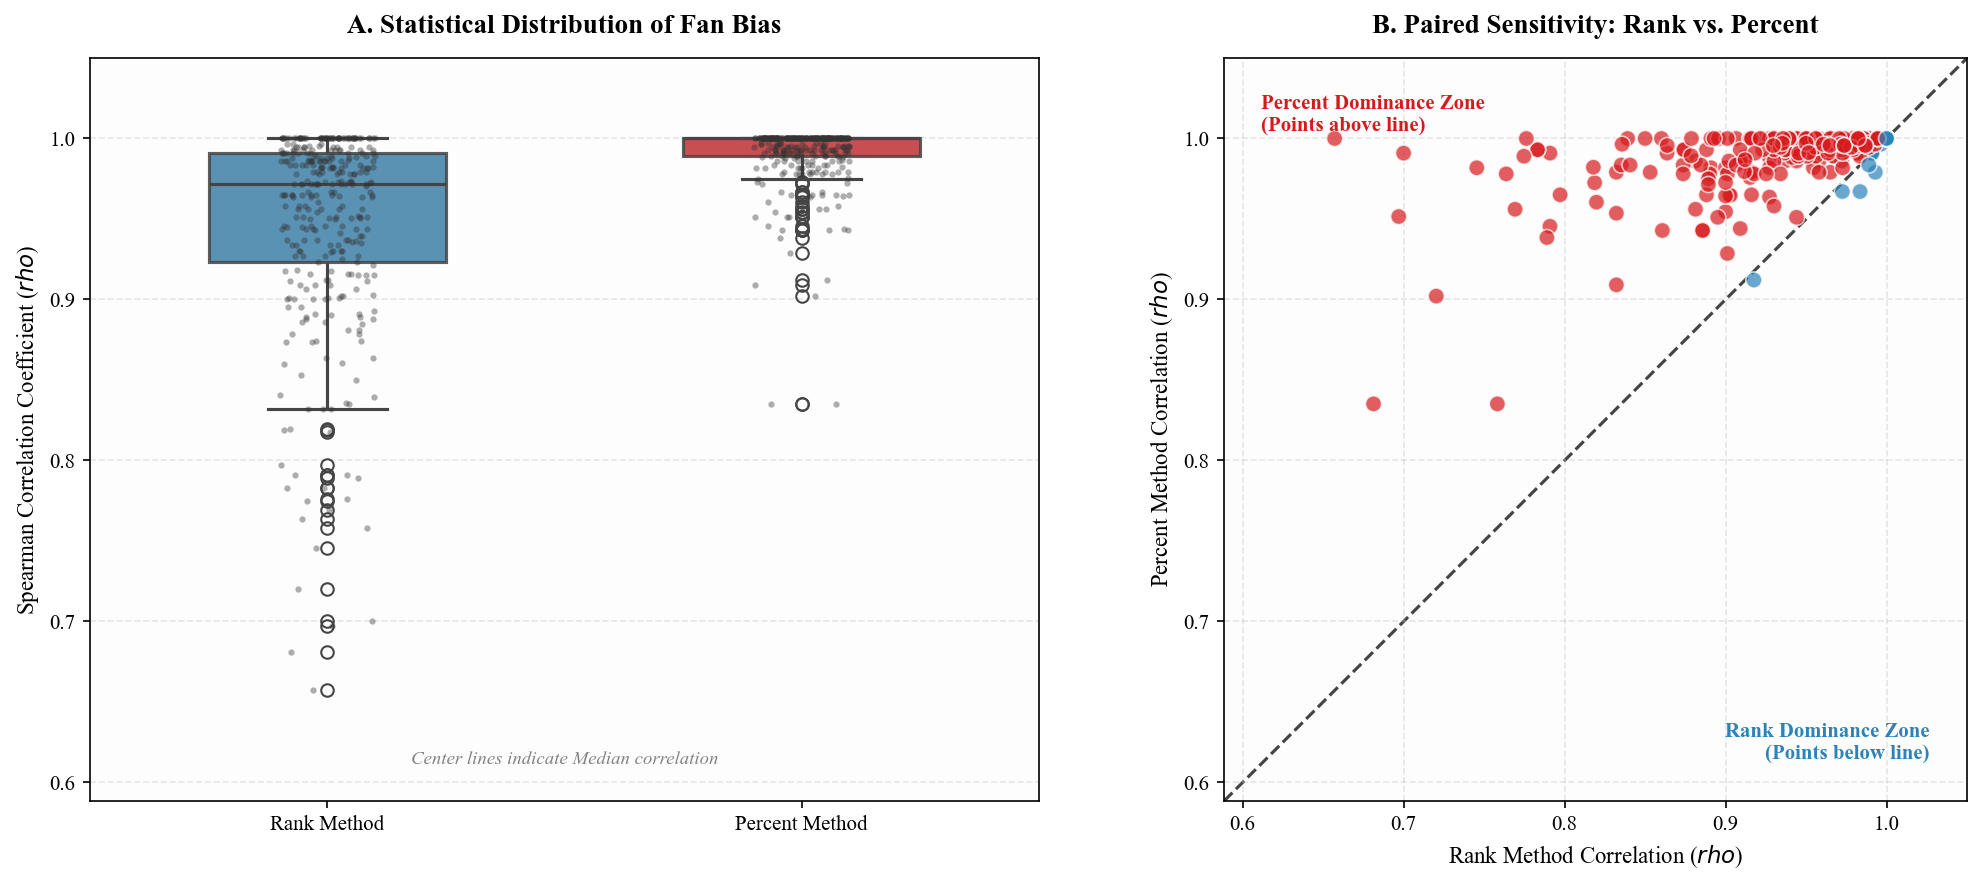

In [8]:
# ==============================================================================
# Task 2 Visualization V3: Focused Boxplot & Scatter (Zoomed & Centered)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_bias_focused_zoomed(df_analysis):
    """
    只绘制箱线图和散点图。
    自动调整坐标轴范围，使数据居中显示，不再从0开始。
    """
    if df_analysis is None or 'rho_rank_vs_fan' not in df_analysis.columns:
        print("错误: 数据集为空。")
        return

    # 1. 样式设置 (MCM Standard)
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.labelsize": 12, "axes.titlesize": 13,
        "figure.dpi": 150, "axes.grid": True,
        "grid.alpha": 0.3, "grid.linestyle": "--",
        "axes.facecolor": "#fdfdfd"
    })

    # 2. 数据准备
    # 为了计算坐标轴范围，我们需要所有相关系数的合集
    valid_data = df_analysis.dropna(subset=['rho_rank_vs_fan', 'rho_pct_vs_fan'])
    all_values = np.concatenate([valid_data['rho_rank_vs_fan'], valid_data['rho_pct_vs_fan']])
    
    # 动态计算范围 (Zoom in)
    data_min = np.min(all_values)
    data_max = np.max(all_values)
    
    # 设置缓冲 (Buffer)，让图不贴边
    # 如果数据本身差距很小，给至少 0.1 的显示范围
    spread = max(data_max - data_min, 0.1)
    y_lower = max(0, data_min - spread * 0.2) # 下界留 20% 空间
    y_upper = min(1.05, data_max + spread * 0.15) # 上界略微超过1一点点以便显示

    # 准备箱线图数据
    dist_melt = df_analysis.melt(id_vars=['season', 'week'], 
                                 value_vars=['rho_rank_vs_fan', 'rho_pct_vs_fan'], 
                                 var_name='Method', value_name='Correlation')
    label_map = {
        'rho_rank_vs_fan': 'Rank Method',
        'rho_pct_vs_fan': 'Percent Method'
    }
    dist_melt['Method'] = dist_melt['Method'].map(label_map)

    # 配色 (Blue=Rank, Red=Percent)
    c_rank = "#2b83ba"
    c_pct = "#d7191c"
    pal = [c_rank, c_pct]

    # 3. 创建画布 (1行2列)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.subplots_adjust(wspace=0.25) # 调整左右间距

    # =========================================================
    # Plot 1: Box Plot (Distribution)
    # =========================================================
    ax1 = axes[0]
    
    # 绘制箱体
    sns.boxplot(data=dist_melt, x='Method', y='Correlation', palette=pal, 
                width=0.5, ax=ax1, linewidth=1.5,
                boxprops=dict(alpha=0.85, edgecolor='#444'))
    
    # 添加抖动散点 (Jitter Points) 以显示具体数据分布
    sns.stripplot(data=dist_melt, x='Method', y='Correlation', color="#333", 
                  size=3, alpha=0.4, ax=ax1, jitter=True)

    ax1.set_ylim(y_lower, y_upper)
    ax1.set_title("A. Statistical Distribution of Fan Bias", fontweight='bold', pad=12)
    ax1.set_ylabel("Spearman Correlation Coefficient ($rho$)", fontsize=11)
    ax1.set_xlabel("") # 移除X轴标签，因为刻度已经很清楚了
    
    # 添加中位数线说明
    ax1.text(0.5, 0.05, "Center lines indicate Median correlation", 
             transform=ax1.transAxes, ha='center', fontsize=9, color='gray', style='italic')

    # =========================================================
    # Plot 2: Scatter Plot (Paired Comparison)
    # =========================================================
    ax2 = axes[1]
    
    # 颜色逻辑
    colors = np.where(valid_data['rho_pct_vs_fan'] > valid_data['rho_rank_vs_fan'], c_pct, c_rank)
    
    # 绘制散点
    ax2.scatter(valid_data['rho_rank_vs_fan'], valid_data['rho_pct_vs_fan'], 
                c=colors, alpha=0.7, s=60, edgecolors='white', linewidth=0.8, zorder=2)
    
    # 绘制对角线 y=x
    ax2.plot([y_lower, y_upper], [y_lower, y_upper], 
             color='#444', linestyle='--', linewidth=1.5, zorder=1, label='y=x (Equal Bias)')
    
    # 设置两轴相同的比例，方便对比
    ax2.set_xlim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)
    ax2.set_aspect('equal') # 保证正方形，这是对比图的关键
    
    ax2.set_title("B. Paired Sensitivity: Rank vs. Percent", fontweight='bold', pad=12)
    ax2.set_xlabel("Rank Method Correlation ($rho$)", fontsize=11)
    ax2.set_ylabel("Percent Method Correlation ($rho$)", fontsize=11)
    
    # 区域标记 (根据现在的坐标轴范围动态定位)
    # 左上角 (Percent 优势区)
    ax2.text(y_lower + (y_upper-y_lower)*0.05, y_upper - (y_upper-y_lower)*0.05, 
             "Percent Dominance Zone\n(Points above line)", 
             color=c_pct, fontsize=10, fontweight='bold', ha='left', va='top')
    
    # 右下角 (Rank 优势区)
    ax2.text(y_upper - (y_upper-y_lower)*0.05, y_lower + (y_upper-y_lower)*0.05, 
             "Rank Dominance Zone\n(Points below line)", 
             color=c_rank, fontsize=10, fontweight='bold', ha='right', va='bottom')

    # 4. 整体调整
    plt.tight_layout()
    plt.show()

# --- 运行 ---
if __name__ == "__main__":
    if 'df_analysis' in locals():
        print("正在绘制聚焦版分析图 (Zoomed In)...")
        plot_bias_focused_zoomed(df_analysis)
    else:
        print("请先运行 Task 2 仿真代码。")


## Task2.2

In [9]:
import pandas as pd
import numpy as np
import re
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. 数据读取与清洗
# ==========================================
path = "2026_MCM_Problem_C_Data.csv"
try:
    df = pd.read_csv(path)
    print(f"成功读取原始数据: {path}")
except FileNotFoundError:
    print(f"❌ 错误: 找不到文件 {path}")
    exit()

# 1) 把淘汰后填的 0 分当作缺失
judge_score_cols = [c for c in df.columns if re.match(r"week\d+_judge\d+_score", c)]
df[judge_score_cols] = df[judge_score_cols].replace(0, np.nan)

# 2) 每周总分（4 位评委相加）
weeks = range(1, 12)  # week1..week11
for w in weeks:
    cols = [f"week{w}_judge{j}_score" for j in range(1, 5)]
    # min_count=1 确保如果全是 NaN 则结果为 NaN，而不是 0
    df[f"week{w}_total"] = df[cols].sum(axis=1, min_count=1)

total_cols = [f"week{w}_total" for w in weeks]

# 3) 评委“平均周总分”（只在有效周上求均值）
df["judge_avg_per_week"] = df[total_cols].mean(axis=1, skipna=True)

# 4) 计算每周“当周参赛者内”的评委排名百分位
rank_frames = []
for w in weeks:
    col = f"week{w}_total"
    if col not in df.columns: continue
    
    tmp = df[["season", "celebrity_name", col]].dropna(subset=[col]).copy()
    # 排名：分数高 -> rank 小(1)
    tmp["judge_rank"] = tmp.groupby("season")[col].rank(method="average", ascending=False)
    tmp["n_week"] = tmp.groupby("season")[col].transform("count")
    # 百分位：0=Best, 1=Worst
    tmp["judge_pct"] = (tmp["judge_rank"] - 1) / (tmp["n_week"] - 1)
    tmp["week"] = w
    rank_frames.append(tmp[["season", "celebrity_name", "week", "judge_rank", "n_week", "judge_pct"]])

if rank_frames:
    ranks = pd.concat(rank_frames, ignore_index=True)
    ranks["last"] = ranks["judge_rank"] == ranks["n_week"]

    stats = ranks.groupby(["season", "celebrity_name"]).agg(
        weeks=("week", "count"),
        avg_weekly_pct=("judge_pct", "mean"),
        last_weeks=("last", "sum"),
    ).reset_index()
else:
    stats = pd.DataFrame(columns=["season", "celebrity_name", "weeks", "avg_weekly_pct", "last_weeks"])

# 5) 季内：用 judge_avg_per_week 得到“评委名次”
df["judge_avg_rank"] = df.groupby("season")["judge_avg_per_week"].rank(method="average", ascending=False)

base = df[["season", "celebrity_name", "placement", "results", "judge_avg_rank"]].drop_duplicates()
base = base.merge(stats, on=["season", "celebrity_name"], how="left")

# 6) 冲突判定：delta = 最终名次 - 评委名次
# 正数: 最终名次(数值大,差) > 评委名次(数值小,好) -> 评委喜欢但输了 (Fans Against)
# 负数: 最终名次(数值小,好) < 评委名次(数值大,差) -> 评委不喜欢但赢了 (Fans Support)
base["delta_rank"] = base["placement"] - base["judge_avg_rank"]

season_n = (base.groupby("season")["celebrity_name"]
            .nunique()
            .reset_index(name="season_total_competitors"))

base = base.merge(season_n, on="season", how="left")

# 设定阈值 k
k = 4

# Group 1: 粉丝抬上去 (Fans Support / Judge Hates)
fans_support = base[base["delta_rank"] <= -k].sort_values(["delta_rank", "season"])
fans_support.to_csv('fans_support.csv', index=False, encoding="utf-8-sig")

# Group 2: 粉丝压下去 (Fans Against / Judge Loves)
fans_against = base[base["delta_rank"] >=  k].sort_values(["delta_rank", "season"], ascending=[False, True])
fans_against.to_csv('fans_against.csv', index=False, encoding="utf-8-sig")

# 打印结果
cols = ["season","celebrity_name","season_total_competitors","placement","judge_avg_rank","delta_rank","avg_weekly_pct","last_weeks","weeks","results"]
print("=== Fans Support (Judges Low, Final High) ===")
print(fans_support[cols].to_string(index=False))
print("\n=== Fans Against (Judges High, Final Low) ===")
print(fans_against[cols].to_string(index=False))

# 合并保存
merged = pd.concat([fans_support, fans_against], ignore_index=True)
merged = merged.drop_duplicates().reset_index(drop=True)
merged.to_csv("fans_merged.csv", index=False, encoding="utf-8-sig")
print(f"\n[Info] 合并列表已保存至 fans_merged.csv，共 {len(merged)} 条记录。")


成功读取原始数据: 2026_MCM_Problem_C_Data.csv
=== Fans Support (Judges Low, Final High) ===
 season   celebrity_name  season_total_competitors  placement  judge_avg_rank  delta_rank  avg_weekly_pct  last_weeks  weeks            results
     27      Bobby Bones                        13          1             8.0        -7.0        0.810772           2      9          1st Place
      7  Cloris Leachman                        13          7            12.0        -5.0        0.911706           3      6  Eliminated Week 6
     17     Bill Engvall                        12          4             9.0        -5.0        0.887534           6     11 Eliminated Week 11
     19  Michael Waltrip                        13          7            12.0        -5.0        0.916319           4      8  Eliminated Week 8
     21   Alek Skarlatos                        13          3             8.0        -5.0        0.682576           2     11          3rd Place
     27      Joe Amabile                        13  

In [10]:
import pandas as pd

# 文件名定义
file_fans = 'fans_merged.csv'
file_sim = 'task2_simulation_results_v3.csv' # 请确保此文件存在(由Cell 7生成)
output_file = 'result_filtered.csv'

try:
    # 1. 读取 fans_merged.csv 并提取 season 列
    df_fans = pd.read_csv(file_fans)
    target_seasons = df_fans['season'].unique()
    
    print(f"从 {file_fans} 中提取到 {len(target_seasons)} 个目标赛季。")

    # 2. 读取 仿真结果
    df_sim = pd.read_csv(file_sim)

    # 3. 筛选: 目标赛季 & 决赛周
    filtered_df = df_sim[
        (df_sim['season'].isin(target_seasons)) & 
        (df_sim['type'] == 'Final')
    ]

    # 4. 输出
    print(f"筛选完成。符合条件的行数: {len(filtered_df)}")
    # print(filtered_df.head())
    
    filtered_df.to_csv(output_file, index=False)
    print(f"结果已保存为: {output_file}")

except FileNotFoundError as e:
    print(f"❌ 错误: 找不到文件 {e.filename}")
except KeyError as e:
    print(f"❌ 错误: 列名缺失 {e}")


从 fans_merged.csv 中提取到 18 个目标赛季。
筛选完成。符合条件的行数: 18
结果已保存为: result_filtered.csv


In [11]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 数据读取
# ==========================================
# 依赖文件: task2_final_bias_analysis.csv (需包含 full_fan_order 列)
# 如果 task2_final_bias_analysis.csv 不存在，可以使用 result_filtered.csv 或 task2_simulation_results_v3.csv
# 这里假设 task2_simulation_results_v3.csv 已经包含了 full_fan_order (如果 Cell 7 运行完整的话)
# 为了稳健，我们重新加载并生成 fan order

file_sim_full = "task2_simulation_results_v3.csv"
file_raw = "2026_MCM_Problem_C_Data.csv"
file_fans = "fans_support.csv"
file_estimates = "task1_fan_votes_estimated.csv" # 需要估算的票数来重建 fan order

try:
    df_sim = pd.read_csv(file_sim_full)
    df_raw = pd.read_csv(file_raw)
    df_fans = pd.read_csv(file_fans)
    df_est = pd.read_csv(file_estimates)
except FileNotFoundError:
    print("❌ 错误：缺少必要的 CSV 文件 (Sim, Raw, Fans, or Estimates)。")
    # 停止运行此 Cell
    raise

# 辅助函数: 重建 Fan Order (如果 Sim 文件里没有)
def get_fan_order_list(season, week, df_est, active_names_str):
    sub = df_est[(df_est["season"]==season) & (df_est["week"]==week)]
    if sub.empty: return []
    # 获取 active names
    if pd.isna(active_names_str): return []
    actives = [x.strip() for x in active_names_str.split(',')]
    
    name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
    # 排序
    sorted_names = sorted(actives, key=lambda x: name_map.get(x, -1), reverse=True)
    return sorted_names

def get_judge_score_sum(season, week, name, raw_df):
    name = name.strip()
    week_cols = [f"week{week}_judge{j}_score" for j in range(1, 5)]
    valid_cols = [c for c in week_cols if c in raw_df.columns]
    row = raw_df[(raw_df['season'] == season) & (raw_df['celebrity_name'] == name)]
    if row.empty or not valid_cols: return 0
    return row[valid_cols].sum(axis=1).values[0]

# ==========================================
# 2. 仿真主循环
# ==========================================
results = []
print(f"正在对 {len(df_fans)} 位'粉丝宠儿'进行 Rank制 + Bottom 2 生存测试...")

for _, target_row in df_fans.iterrows():
    season = target_row['season']
    name = target_row['celebrity_name']
    actual_placement = target_row['placement']
    
    # 获取该赛季事件
    season_events = df_sim[df_sim['season'] == season].sort_values('week')
    
    new_rank = 999
    outcome = "Unchanged"
    eliminated_week = None
    
    for _, event_row in season_events.iterrows():
        week = event_row['week']
        
        # 1. 获取当周名单 (按粉丝投票排序)
        # 优先从列读取，如果没有则实时计算
        if 'full_fan_order' in event_row and not pd.isna(event_row['full_fan_order']):
             full_fan_list = [x.strip() for x in event_row['full_fan_order'].split(',')]
        else:
             full_fan_list = get_fan_order_list(season, week, df_est, event_row['full_rank_order'])
             
        if not full_fan_list: continue
        
        # 2. 筛选在场选手 (有评委分)
        active_contestants = []
        scores_map = {}
        for cand in full_fan_list:
            sc = get_judge_score_sum(season, week, cand, df_raw)
            if sc > 0:
                active_contestants.append(cand)
                scores_map[cand] = sc
        
        if name not in active_contestants: break # 已不在场
        n_active = len(active_contestants)
        if n_active < 2: break
        
        # 3. 计算 Rank
        # Judge Rank (分数降序)
        sorted_by_score = sorted(active_contestants, key=lambda x: scores_map[x], reverse=True)
        j_rank_map = {}
        curr_s, curr_r = -1, 0
        for i, cand in enumerate(sorted_by_score):
            if scores_map[cand] != curr_s:
                curr_s = scores_map[cand]
                curr_r = i + 1
            j_rank_map[cand] = curr_r
            
        # Fan Rank (列表本身有序)
        f_rank_map = {cand: i+1 for i, cand in enumerate(active_contestants)}
        
        # 4. Determine Bottom 2
        combined = []
        for cand in active_contestants:
            combined.append({
                'name': cand, 
                'total': j_rank_map[cand] + f_rank_map[cand],
                'j_score': scores_map[cand]
            })
        combined.sort(key=lambda x: x['total']) # 升序 (Rank 1 best)
        
        bottom_2 = combined[-2:] # 最后两名
        
        # 5. 生存判定
        in_bottom_2 = False
        opponent = None
        if bottom_2[-1]['name'] == name:
            in_bottom_2 = True; opponent = bottom_2[-2]
        elif bottom_2[-2]['name'] == name:
            in_bottom_2 = True; opponent = bottom_2[-1]
            
        if in_bottom_2:
            # 评委裁决: 分数低者走
            if scores_map[name] < opponent['j_score']:
                new_rank = n_active
                outcome = "Eliminated Earlier"
                eliminated_week = week
                break # 淘汰
            # 如果分数高或平，幸存

    # 记录
    try: old_r = float(actual_placement)
    except: old_r = 0
    
    final_rank_display = int(new_rank) if new_rank != 999 else old_r
    change = old_r - final_rank_display # Positive if Old > New (Rank improved?), wait
    # Rank数值: 1是好，10是坏。
    # 如果 Old=5, New=9 (变差)。Change = 5-9 = -4. 
    # 我们希望 Change < 0 表示变差。
    
    results.append({
        "Season": season, "Name": name,
        "Actual Rank": old_r, "Sim Rank": final_rank_display,
        "Change": change,
        "Elim Week": eliminated_week if eliminated_week else "-",
        "Outcome": outcome
    })

df_res_support = pd.DataFrame(results).sort_values("Change")
print(f"\n[结果] {len(df_res_support[df_res_support['Outcome']=='Eliminated Earlier'])} 人被提前淘汰。")
print(df_res_support.head(10).to_string(index=False))
df_res_support.to_csv("task2_fans_support_simulation.csv", index=False)


正在对 18 位'粉丝宠儿'进行 Rank制 + Bottom 2 生存测试...

[结果] 14 人被提前淘汰。
 Season             Name  Actual Rank  Sim Rank  Change Elim Week            Outcome
     31 Vinny Guadagnino          7.0      12.0    -5.0         5 Eliminated Earlier
     17     Bill Engvall          4.0       8.0    -4.0         6 Eliminated Earlier
     29            Nelly          3.0       7.0    -4.0         9 Eliminated Earlier
     27      Bobby Bones          1.0       4.0    -3.0         9 Eliminated Earlier
     11    Bristol Palin          3.0       6.0    -3.0         7 Eliminated Earlier
     30      Cody Rigsby          3.0       6.0    -3.0         9 Eliminated Earlier
     19  Michael Waltrip          7.0       9.0    -2.0         5 Eliminated Earlier
      2       Jerry Rice          2.0       4.0    -2.0         7 Eliminated Earlier
     24       David Ross          2.0       4.0    -2.0         9 Eliminated Earlier
      7  Cloris Leachman          7.0       9.0    -2.0         3 Eliminated Earlier


In [12]:
# ==========================================
# 仿真 B: 意难平选手续命
# ==========================================
# 依赖文件: task2_simulation_results_v3.csv, 2026_MCM_Problem_C_Data.csv, fans_against.csv

try:
    df_against = pd.read_csv("fans_against.csv")
except:
    print("❌ 找不到 fans_against.csv，请先运行 Cell 11。")
    df_against = pd.DataFrame()

results_against = []

if not df_against.empty:
    print(f"\n正在对 {len(df_against)} 位'高分低人气'选手进行续命仿真...")
    
    for _, target_row in df_against.iterrows():
        season = target_row['season']
        name = target_row['celebrity_name']
        
        # 计算平均战力
        p_scores = []
        max_week = df_sim[df_sim['season']==season]['week'].max()
        for w in range(1, max_week + 1):
            s = get_judge_score_sum(season, w, name, df_raw)
            if s > 0: p_scores.append(s)
        if not p_scores: continue
        avg_score = np.mean(p_scores)
        actual_weeks = len(p_scores)
        
        # 开始仿真
        season_events = df_sim[df_sim['season'] == season].sort_values('week')
        sim_survive = 0
        
        for _, event_row in season_events.iterrows():
            week = event_row['week']
            
            # 获取名单
            if 'full_fan_order' in event_row and not pd.isna(event_row['full_fan_order']):
                 full_fan_list = [x.strip() for x in event_row['full_fan_order'].split(',')]
            else:
                 full_fan_list = get_fan_order_list(season, week, df_est, event_row['full_rank_order'])
            
            # 构建虚拟竞技场
            arena = []
            for opp in full_fan_list:
                if opp == name:
                    s = get_judge_score_sum(season, week, name, df_raw)
                    score = s if s > 0 else avg_score # 用均分填补
                else:
                    score = get_judge_score_sum(season, week, opp, df_raw)
                
                if score > 0 or opp == name:
                    arena.append({'name': opp, 'score': score})
            
            if len(arena) < 2: continue
            
            # 排位
            arena.sort(key=lambda x: x['score'], reverse=True)
            j_rank_map = {x['name']: i+1 for i, x in enumerate(arena)}
            
            # 简化：假设他在粉丝中排名靠后 (例如倒数第2，既然他是fans_against)
            # 或者按 fan list 相对顺序
            active_fan = [x['name'] for x in arena] # arena 顺序是 judge 顺序
            # 重新按 fan list 排序以获取 fan rank
            sorted_fan = sorted(active_fan, key=lambda x: full_fan_list.index(x) if x in full_fan_list else 999)
            f_rank_map = {cand: i+1 for i, cand in enumerate(sorted_fan)}
            
            # Bottom 2
            combined = []
            for cand in active_fan:
                combined.append({'name': cand, 'total': j_rank_map[cand] + f_rank_map[cand]})
            combined.sort(key=lambda x: x['total'])
            
            bottom_2_names = [x['name'] for x in combined[-2:]]
            
            survived = True
            if name in bottom_2_names:
                # 评委裁决
                # 找到对手
                opp_name = bottom_2_names[0] if bottom_2_names[1] == name else bottom_2_names[1]
                # 找分
                my_s = next(item['score'] for item in arena if item['name'] == name)
                opp_s = next(item['score'] for item in arena if item['name'] == opp_name)
                
                if my_s < opp_s: survived = False
            
            if survived:
                sim_survive = week
            else:
                break # 死了
        
        gain = sim_survive - actual_weeks
        results_against.append({
            "Season": season, "Name": name,
            "Actual Weeks": actual_weeks, "Sim Weeks": sim_survive,
            "Gain": gain
        })

    df_res_against = pd.DataFrame(results_against).sort_values("Gain", ascending=False)
    print(f"\n[结果] {len(df_res_against[df_res_against['Gain']>0])} 人成功续命。")
    print(df_res_against.head(10).to_string(index=False))
    df_res_against.to_csv("task2_fans_against_simulation.csv", index=False)
else:
    df_res_against = pd.DataFrame()
    print("没有 Fans Against 数据，跳过仿真。")



正在对 7 位'高分低人气'选手进行续命仿真...

[结果] 6 人成功续命。
 Season               Name  Actual Weeks  Sim Weeks  Gain
      4  Paulina Porizkova             2          8     6
     13    Chynna Phillips             4          8     4
     27            Tinashe             4          8     4
     24     Heather Morris             6          8     2
      5      Sabrina Bryan             6          8     2
     34    Whitney Leavitt            10         11     1
     27 Juan Pablo Di Pace             8          8     0


正在生成新配色的 Task 2 终极图表...


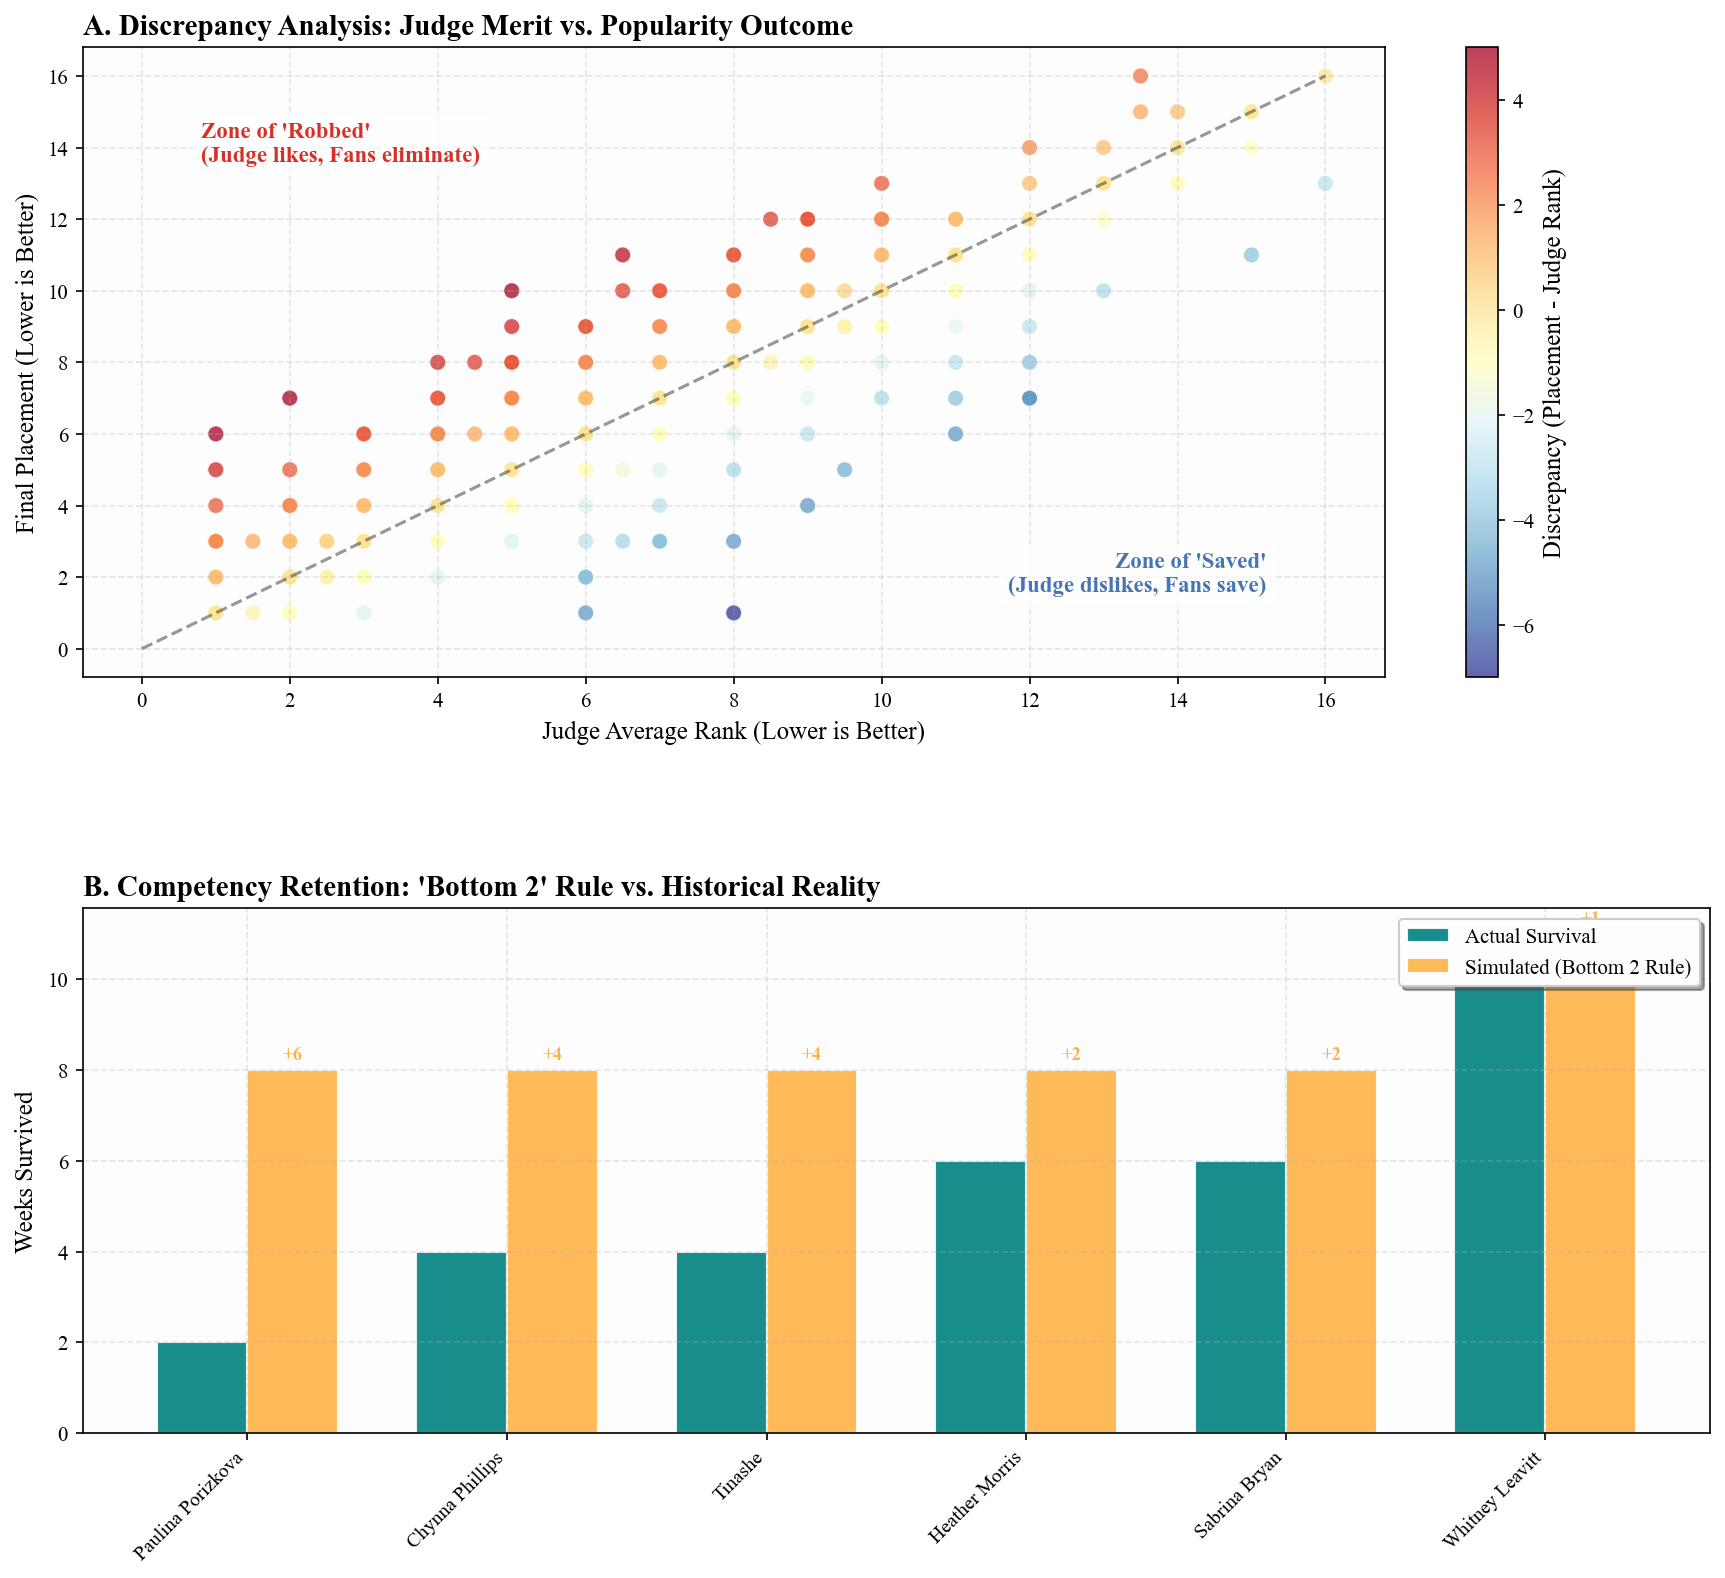

In [13]:
# ==============================================================================
# Task 2 Advanced Visualization: Conflict Analysis & Survival Impact (New Colors)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches

def plot_task2_conflicts_and_survival(df_base, df_res_against):
    """
    df_base: 包含 'judge_avg_rank' 和 'placement' 的全量数据
    df_res_against: 续命仿真结果
    """
    # 1. 设置风格
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.labelsize": 12, "axes.titlesize": 14,
        "figure.dpi": 150, "axes.grid": True,
        "grid.alpha": 0.3, "grid.linestyle": "--",
        "axes.facecolor": "#fdfdfd"
    })
    
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[1.2, 1], hspace=0.4)
    
    # ---------------------------------------------------------
    # Plot 1: The "Conflict Scatter" (Judge Rank vs Final Placement)
    # ---------------------------------------------------------
    ax1 = fig.add_subplot(gs[0])
    
    # 准备数据
    plot_data = df_base.dropna(subset=['judge_avg_rank', 'placement']).copy()
    plot_data['delta'] = plot_data['placement'] - plot_data['judge_avg_rank']
    
    # 绘制散点 (使用 RdYlBu_r: Red=Conflict/Robbed, Blue=Support/Saved)
    sc = ax1.scatter(
        plot_data['judge_avg_rank'], 
        plot_data['placement'], 
        c=plot_data['delta'], 
        cmap='RdYlBu_r', 
        s=60, alpha=0.75, edgecolors='w', linewidth=0.6
    )
    
    # 对角线
    max_val = max(plot_data['judge_avg_rank'].max(), plot_data['placement'].max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.4, linewidth=1.5, label='Perfect Alignment')
    
    # 区域标注
    ax1.text(max_val*0.05, max_val*0.85, "Zone of 'Robbed'\n(Judge likes, Fans eliminate)", 
             color='#d73027', fontsize=11, fontweight='bold', ha='left',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
             
    ax1.text(max_val*0.95, max_val*0.1, "Zone of 'Saved'\n(Judge dislikes, Fans save)", 
             color='#4575b4', fontsize=11, fontweight='bold', ha='right',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    ax1.set_xlabel("Judge Average Rank (Lower is Better)")
    ax1.set_ylabel("Final Placement (Lower is Better)")
    ax1.set_title("A. Discrepancy Analysis: Judge Merit vs. Popularity Outcome", fontweight='bold', loc='left')
    
    cbar = plt.colorbar(sc, ax=ax1)
    cbar.set_label("Discrepancy (Placement - Judge Rank)")

    # ---------------------------------------------------------
    # Plot 2: Survival Gain Bar Chart (New Colors: Teal & Orange)
    # ---------------------------------------------------------
    ax2 = fig.add_subplot(gs[1])
    
    if not df_res_against.empty:
        # 取前 15 名续命最成功的
        top_gainers = df_res_against[df_res_against['Gain'] > 0].head(15)
        
        if not top_gainers.empty:
            x = np.arange(len(top_gainers))
            width = 0.35
            
            # --- 新配色 ---
            # c_actual = "#1f78b4"  # 深青色 (Cool/History)
            # c_sim    = "#ff7f00"  # 金橙色 (Warm/Potential)
            # 或者更时尚的：
            c_actual = "#008080"  # Teal
            c_sim    = "#ffb347"  # Pastel Orange
            
            # 绘制柱状图
            rects1 = ax2.bar(x - width/2, top_gainers['Actual Weeks'], width, 
                             label='Actual Survival', color=c_actual, alpha=0.9, edgecolor='white')
            
            rects2 = ax2.bar(x + width/2, top_gainers['Sim Weeks'], width, 
                             label='Simulated (Bottom 2 Rule)', color=c_sim, alpha=0.9, edgecolor='white')
            
            ax2.set_ylabel("Weeks Survived")
            ax2.set_title("B. Competency Retention: 'Bottom 2' Rule vs. Historical Reality", fontweight='bold', loc='left')
            ax2.set_xticks(x)
            ax2.set_xticklabels(top_gainers['Name'], rotation=45, ha='right', fontsize=9.5)
            
            # 优化图例
            ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
            
            # 标数值 (显示增量)
            for i, gain in enumerate(top_gainers['Gain']):
                # 在模拟柱子上方标注 "+N"
                h_sim = top_gainers['Sim Weeks'].iloc[i]
                ax2.annotate(f'+{int(gain)}', 
                             xy=(x[i] + width/2, h_sim),
                             xytext=(0, 3), textcoords="offset points",
                             ha='center', va='bottom', fontsize=9, color=c_sim, fontweight='bold')
                
        else:
            ax2.text(0.5, 0.5, "No significant survival gains found.", ha='center')
    else:
        ax2.text(0.5, 0.5, "No 'Fans Against' data available.", ha='center')

    plt.tight_layout()
    plt.show()

# --- 运行绘图 ---
if 'base' in globals() and 'df_res_against' in globals():
    print("正在生成新配色的 Task 2 终极图表...")
    plot_task2_conflicts_and_survival(base, df_res_against)
else:
    print("❌ 缺少数据。请先运行前面的 Cells。")


# Task3

In [14]:
# ==============================================================================
# Task 3: 明星特征、舞者及地域来源的量化回归分析 (Logic & Modeling)
# ==============================================================================
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 忽略 Sklearn 版本警告
warnings.filterwarnings('ignore')

def task3_comprehensive_analysis(events, final_ens, raw_csv_path):
    print("\n=== Task 3: Analyzing Impact of Characteristics, Dancers & Origins ===")
    
    # ---------------------------------------------------------
    # 1. 数据准备：提取评委分与粉丝票，并进行周内标准化 (Within-Week Z-Score)
    # ---------------------------------------------------------
    print("Step 1: Preparing normalized performance metrics...")
    
    # (A) 处理评委分数
    judge_records = []
    for (s, w), ev in events.items():
        scores = ev.j_scores
        # 标准化处理
        if len(scores) < 2 or scores.std() == 0:
            z_scores = np.zeros_like(scores)
        else:
            z_scores = (scores - scores.mean()) / scores.std()
            
        for name, raw_s, z_s in zip(ev.active_names, scores, z_scores):
            judge_records.append({
                "season": s, "week": w, "celebrity_name": name,
                "z_judge_score": z_s
            })
    df_judge = pd.DataFrame(judge_records)
    
    # (B) 处理粉丝票数
    fan_records = []
    # 确保 final_ens 按周分组
    groups = final_ens.groupby(['season', 'week'])
    for (s, w), g in groups:
        shares = g['vote_share_ens'].values
        # Log 变换 + 标准化 (Log用于处理票数长尾分布)
        log_shares = np.log(shares + 1e-6) 
        if len(log_shares) < 2 or log_shares.std() == 0:
            z_shares = np.zeros_like(log_shares)
        else:
            z_shares = (log_shares - log_shares.mean()) / log_shares.std()
            
        for name, share, z_s in zip(g['celebrity_name'], shares, z_shares):
            fan_records.append({
                "season": s, "week": w, "celebrity_name": name,
                "vote_share": share, # 保留原始份额供参考
                "z_fan_score": z_s
            })
    df_fan = pd.DataFrame(fan_records)
    
    # (C) 聚合到选手级别 (生涯平均表现)
    # 我们关心的是一个选手"总体上"是否受评委/粉丝偏爱
    contestant_judge = df_judge.groupby(['season', 'celebrity_name'])['z_judge_score'].mean().reset_index()
    contestant_fan = df_fan.groupby(['season', 'celebrity_name'])['z_fan_score'].mean().reset_index()
    
    # 合并目标变量
    df_target = pd.merge(contestant_judge, contestant_fan, on=['season', 'celebrity_name'], how='inner')
    
    # ---------------------------------------------------------
    # 2. 特征工程：读取原始CSV提取特征
    # ---------------------------------------------------------
    print("Step 2: Extracting and engineering static features (States & Countries)...")
    try:
        df_raw = pd.read_csv(raw_csv_path)
    except FileNotFoundError:
        print(f"Error: Raw CSV not found at {raw_csv_path}")
        return

    # 选取需要的列
    # 注意：需确保列名与 CSV 完全一致
    static_cols = ['season', 'celebrity_name', 'celebrity_age_during_season', 
                   'celebrity_industry', 'ballroom_partner', 
                   'celebrity_homestate', 'celebrity_homecountry/region']
                   
    # 去重 (每个选手只需一条静态信息)
    df_static = df_raw[static_cols].drop_duplicates(subset=['season', 'celebrity_name'])
    
    # 合并
    df_model = pd.merge(df_target, df_static, on=['season', 'celebrity_name'], how='inner')
    
    # --- 核心修改：精细化处理来源地 (Origin Logic) ---
    def process_origin(row):
        country = str(row['celebrity_homecountry/region']).strip()
        state = str(row['celebrity_homestate']).strip()
        
        # 判断是否为美国
        is_us = country in ['United States', 'USA', 'U.S.', 'United States of America']
        
        # 指标 1: 美国州 (US_State)
        if is_us and state != 'nan' and state != '':
            us_state = state # 直接用州全名，如 "California"
        else:
            us_state = 'Non-US/Unknown' # 非美国或未知
            
        # 指标 2: 国际国家 (Intl_Country)
        if not is_us and country != 'nan' and country != '':
            intl_country = country # 直接用国家名，如 "England"
        else:
            intl_country = 'USA' # 美国选手归为一类
            
        return pd.Series([us_state, intl_country])

    df_model[['US_State', 'Intl_Country']] = df_model.apply(process_origin, axis=1)

    # --- 行业清洗 ---
    def map_industry(ind):
        ind = str(ind).lower()
        if 'actor' in ind or 'actress' in ind: return 'Actor'
        if 'athlete' in ind or 'olympian' in ind: return 'Athlete'
        if 'singer' in ind or 'music' in ind: return 'Musician'
        if 'tv' in ind or 'reality' in ind: return 'TV Personality'
        return 'Other'
    
    df_model['Industry_Clean'] = df_model['celebrity_industry'].apply(map_industry)

    # ---------------------------------------------------------
    # 3. 建立回归模型 (Dual Ridge Regression)
    # ---------------------------------------------------------
    print("Step 3: Training regression models...")
    
    # 我们将 US_State 和 Intl_Country 同时放入模型
    features = ['celebrity_age_during_season', 'Industry_Clean', 'ballroom_partner', 'US_State', 'Intl_Country']
    X = df_model[features]
    y_judge = df_model['z_judge_score']
    y_fan = df_model['z_fan_score']
    
    # 预处理管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['celebrity_age_during_season']),
            ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=2), # 忽略稀有类别
             ['Industry_Clean', 'ballroom_partner', 'US_State', 'Intl_Country'])
        ])
    
    model_j = Pipeline([('pre', preprocessor), ('reg', Ridge(alpha=1.0))])
    model_f = Pipeline([('pre', preprocessor), ('reg', Ridge(alpha=1.0))])
    
    model_j.fit(X, y_judge)
    model_f.fit(X, y_fan)
    
    # ---------------------------------------------------------
    # 4. 提取系数与分析
    # ---------------------------------------------------------
    print("Step 4: Analyzing impacts...")
    
    # 提取特征名
    try:
        cat_features = model_j.named_steps['pre'].named_transformers_['cat'].get_feature_names_out()
        feature_names = ['Age'] + list(cat_features)
        
        # 提取系数
        cj = model_j.named_steps['reg'].coef_
        cf = model_f.named_steps['reg'].coef_
        
        # 维度修正
        if cj.ndim > 1: cj = cj[0]
        if cf.ndim > 1: cf = cf[0]
        
        # 长度对齐
        if len(cj) > len(feature_names): cj = cj[-len(feature_names):] # 通常截距在前面或不匹配
        if len(cf) > len(feature_names): cf = cf[-len(feature_names):]
        
    except Exception as e:
        print(f"Warning: Coefficient extraction failed: {e}")
        return

    df_coef = pd.DataFrame({
        'Feature': feature_names,
        'Judge_Impact': cj,
        'Fan_Impact': cf
    })
    
    # ---------------------------------------------------------
    # 5. 输出
    # ---------------------------------------------------------
    df_model.to_csv("task3_dataset_with_scores.csv", index=False)
    final_ens.to_csv("task1_fan_estimates_full.csv", index=False)
    df_coef.to_csv("task3_impact_analysis.csv", index=False)
    
    print("\n[Output Files]")
    print("1. task3_impact_analysis.csv (Coefficients)")
    print("2. task3_dataset_with_scores.csv (Dataset)")

    # 打印关键见解 (Insights)
    print("\n=== 🎯 Key Insights Report ===")
    
    # (1) 美国各州影响
    print("\n[🇺🇸 Top 3 US States for Fan Votes]")
    state_rows = df_coef[df_coef['Feature'].str.contains('US_State_') & ~df_coef['Feature'].str.contains('Non-US')]
    if not state_rows.empty:
        top_states = state_rows.sort_values('Fan_Impact', ascending=False).head(3)
        for _, row in top_states.iterrows():
            state_name = row['Feature'].replace('US_State_', '')
            print(f"  * {state_name}: +{row['Fan_Impact']:.3f} SDs (Judge: {row['Judge_Impact']:.3f})")

    # (2) 国际国家影响
    print("\n[🌍 Top 3 International Origins for Fan Votes]")
    intl_rows = df_coef[df_coef['Feature'].str.contains('Intl_Country_') & ~df_coef['Feature'].str.contains('USA')]
    if not intl_rows.empty:
        top_intl = intl_rows.sort_values('Fan_Impact', ascending=False).head(3)
        for _, row in top_intl.iterrows():
            country_name = row['Feature'].replace('Intl_Country_', '')
            print(f"  * {country_name}: +{row['Fan_Impact']:.3f} SDs (Judge: {row['Judge_Impact']:.3f})")

    # (3) 舞者影响
    print("\n[💃 Top 3 Pro Dancers for Fan Votes]")
    dancer_rows = df_coef[df_coef['Feature'].str.contains('ballroom_partner')]
    top_dancers = dancer_rows.sort_values('Fan_Impact', ascending=False).head(3)
    for _, row in top_dancers.iterrows():
        name = row['Feature'].replace('ballroom_partner_', '')
        print(f"  * {name}: +{row['Fan_Impact']:.3f} SDs")

    # (4) 年龄影响
    age_row = df_coef[df_coef['Feature'] == 'Age']
    if not age_row.empty:
        age_impact = age_row['Fan_Impact'].values[0]
        print(f"\n[👴 Age Impact]: {age_impact:.3f} SDs per unit (std) of age.")
    
    print(f"\n[Model R^2] Judge: {model_j.score(X, y_judge):.3f}, Fan: {model_f.score(X, y_fan):.3f}")

# --- 主程序调用 ---
if __name__ == "__main__":
    csv_file_path = "2026_MCM_Problem_C_Data.csv"
    # 检查 Cell 2 是否运行过
    if 'events' in globals() and 'final_ens' in globals():
        task3_comprehensive_analysis(events, final_ens, csv_file_path)
    else:
        print("❌ 请先运行 Task 1 代码块以生成 events 和 final_ens 变量。")



=== Task 3: Analyzing Impact of Characteristics, Dancers & Origins ===
Step 1: Preparing normalized performance metrics...
Step 2: Extracting and engineering static features (States & Countries)...
Step 3: Training regression models...
Step 4: Analyzing impacts...

[Output Files]
1. task3_impact_analysis.csv (Coefficients)
2. task3_dataset_with_scores.csv (Dataset)

=== 🎯 Key Insights Report ===

[🇺🇸 Top 3 US States for Fan Votes]
  * Louisiana: +0.607 SDs (Judge: 0.139)
  * Maine: +0.475 SDs (Judge: 0.364)
  * Utah: +0.471 SDs (Judge: 0.367)

[🌍 Top 3 International Origins for Fan Votes]
  * Brazil: +0.501 SDs (Judge: 0.535)
  * Canada: +0.456 SDs (Judge: 0.255)
  * France: +0.245 SDs (Judge: 0.433)

[💃 Top 3 Pro Dancers for Fan Votes]
  * Derek Hough: +0.824 SDs
  * Daniella Karagach: +0.579 SDs
  * Julianne Hough: +0.459 SDs

[👴 Age Impact]: -0.308 SDs per unit (std) of age.

[Model R^2] Judge: 0.557, Fan: 0.353


## Task3绘图模块


=== Generating Task 3 Visualizations (Light Bar Style) ===


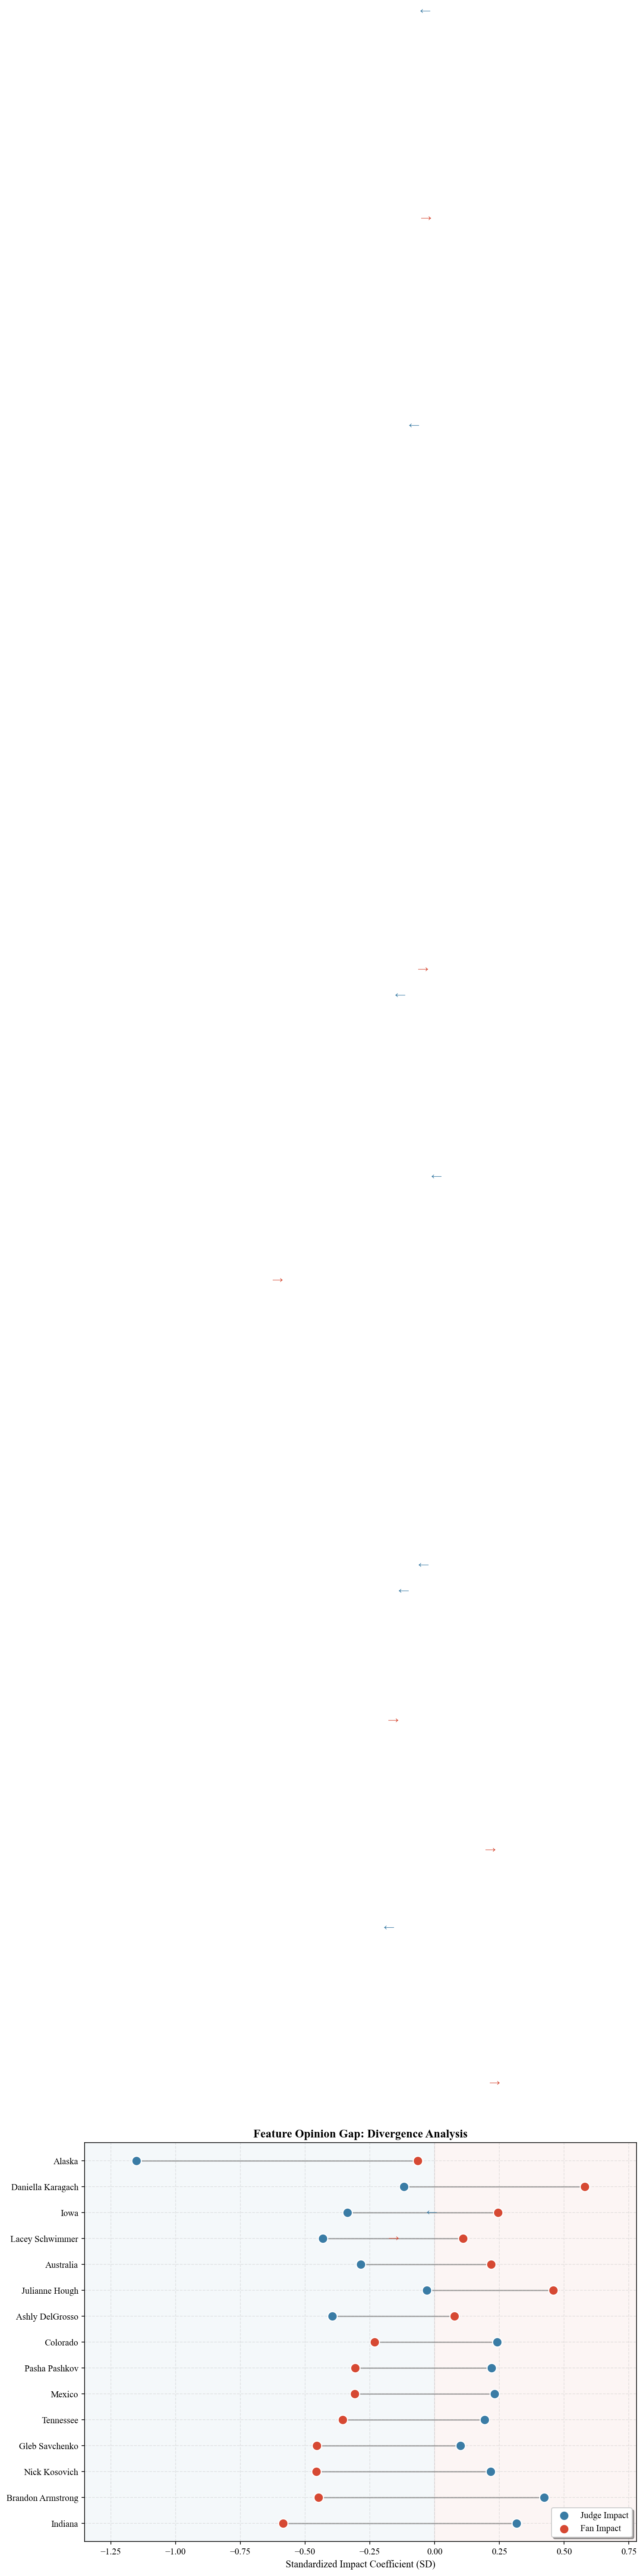

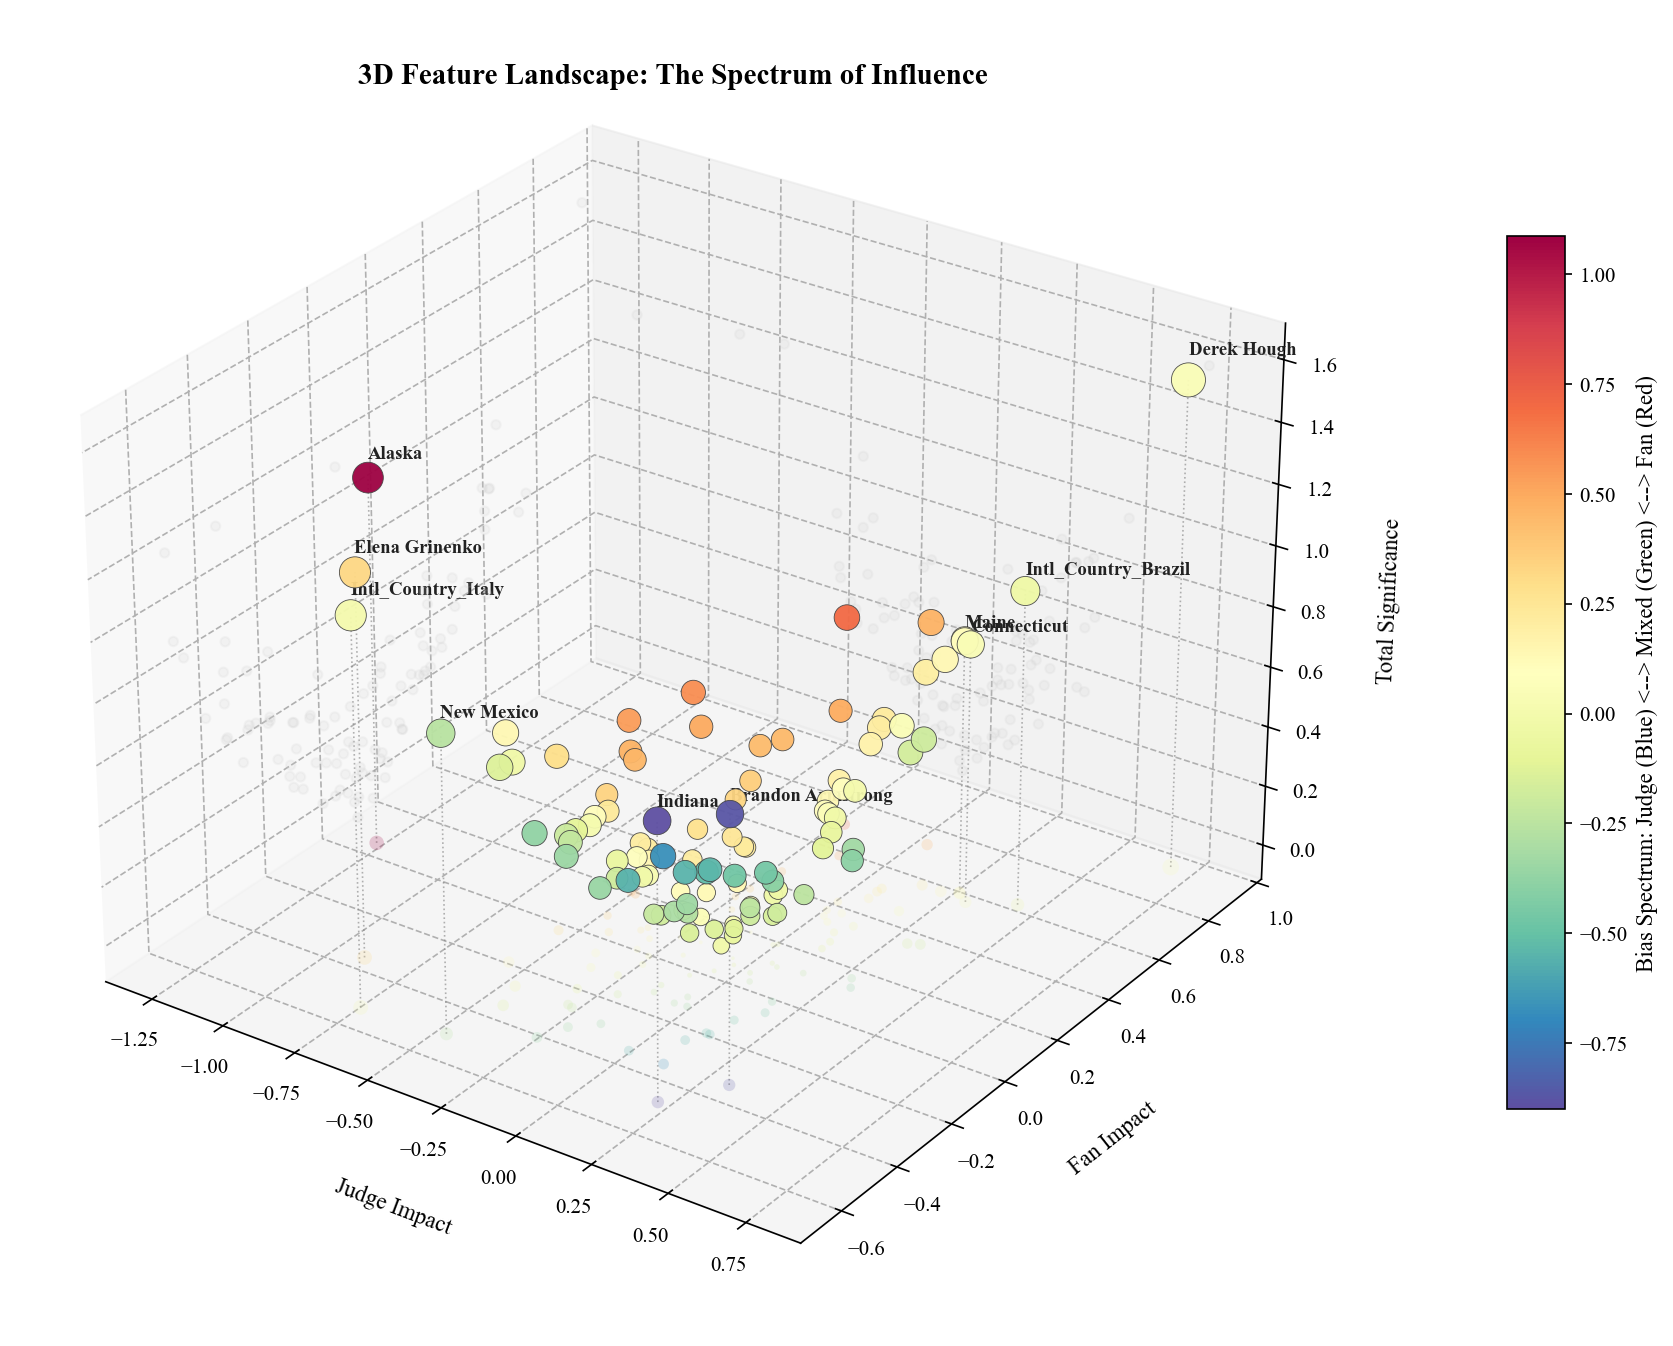

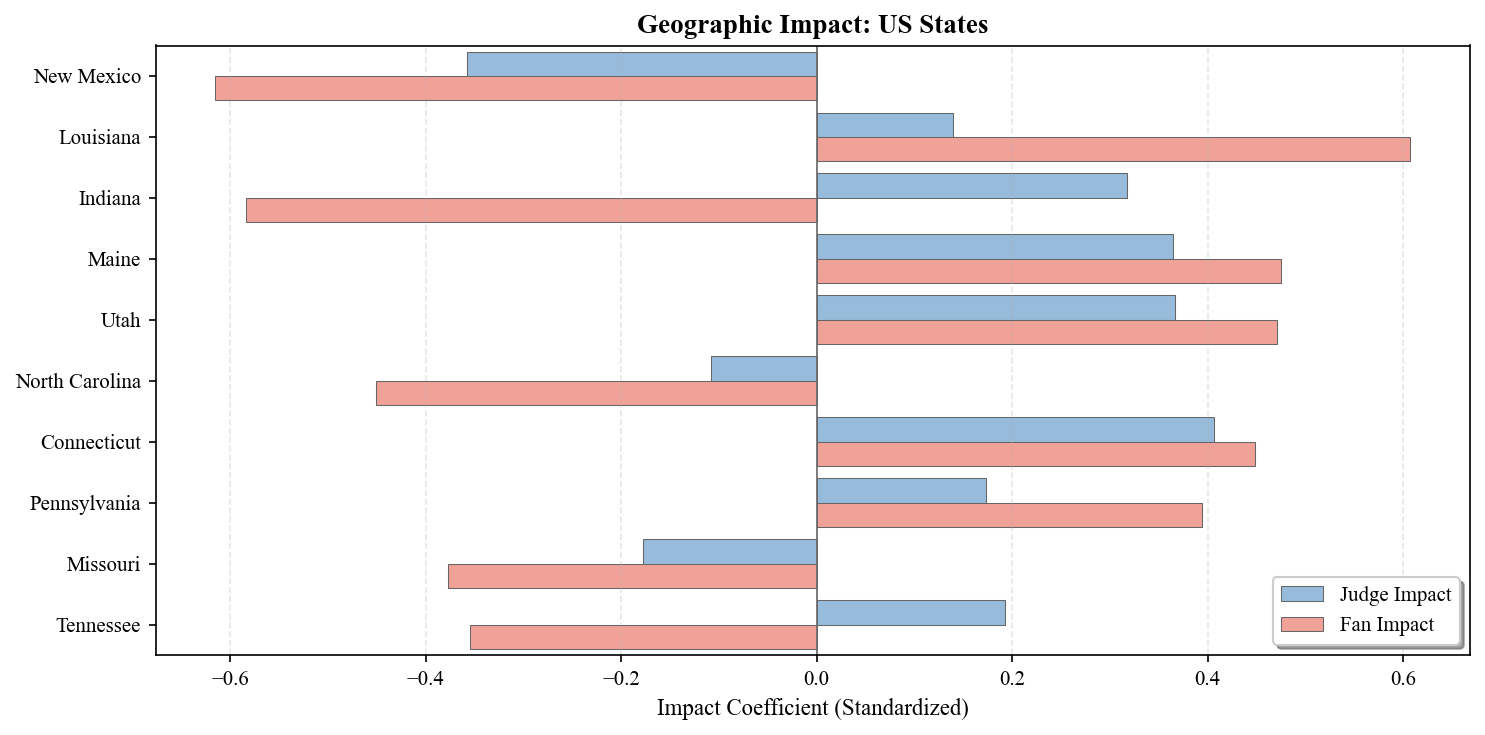

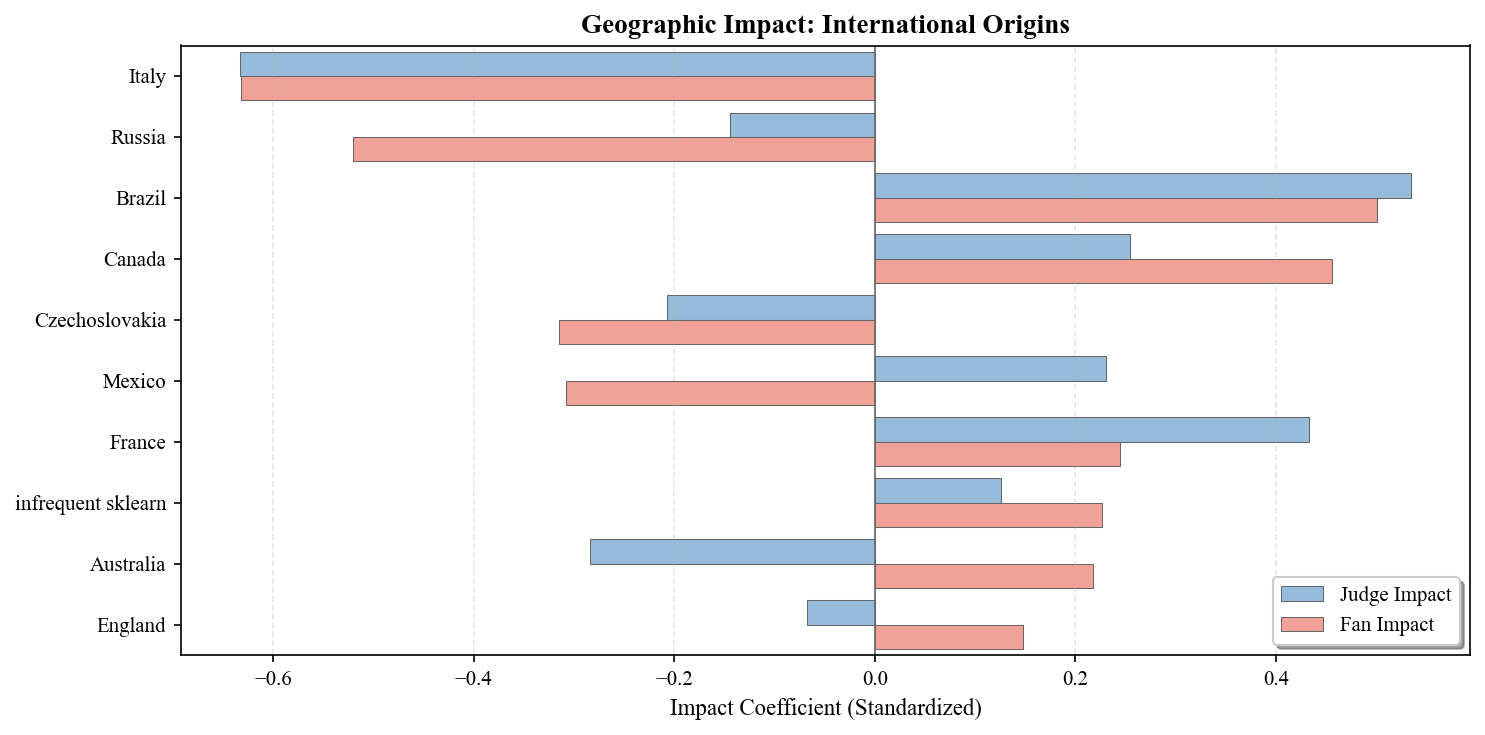

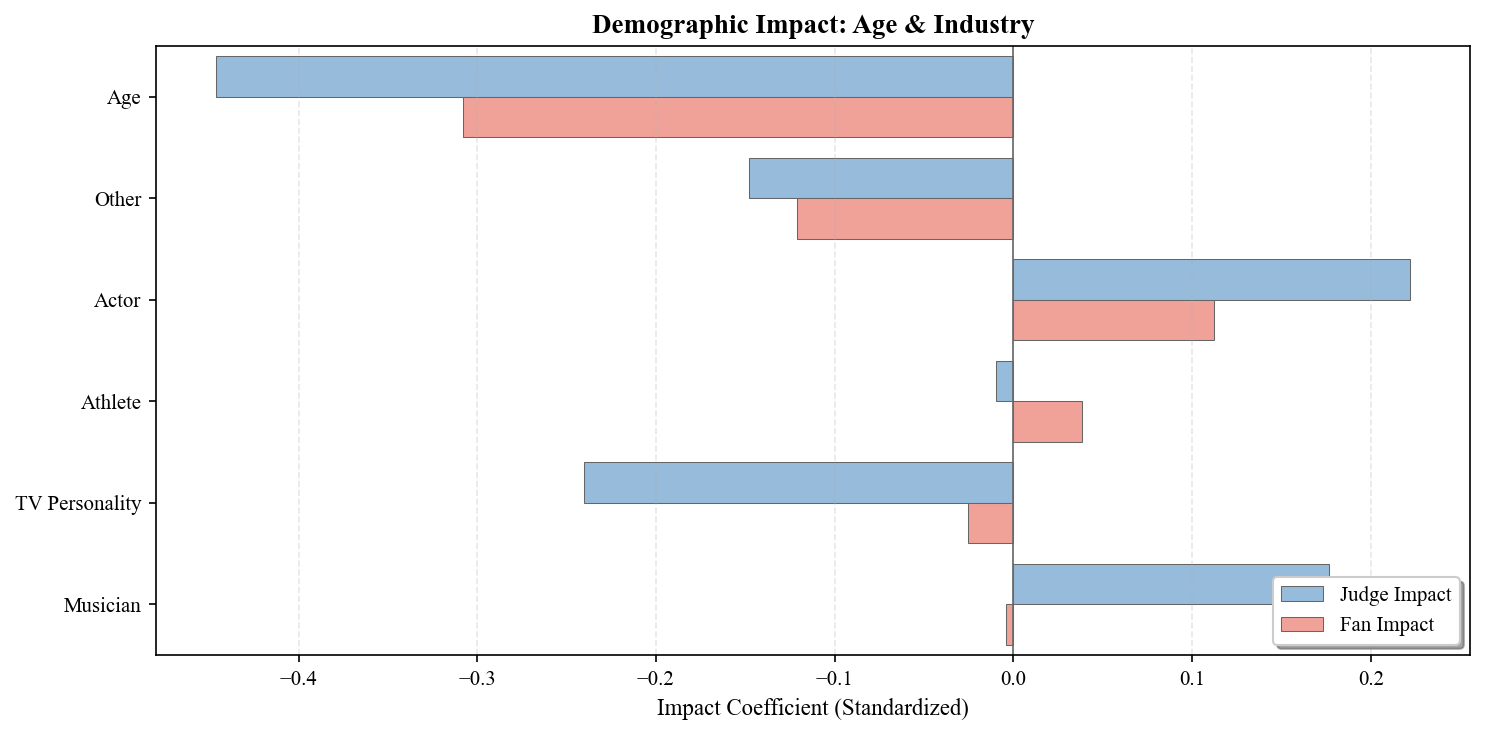

In [15]:
# ==============================================================================
# Task 3 Visualization: Complete Set (Light Bar Charts)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def visualize_task3_complete_light(csv_path="task3_impact_analysis.csv"):
    print(f"\n=== Generating Task 3 Visualizations (Light Bar Style) ===")
    
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print("❌ 错误: 找不到文件 task3_impact_analysis.csv。")
        return

    # -----------------------
    # 1. 配色定义
    # -----------------------
    # A. 棒棒糖图用的标准色 (为了点能看清，保持一定饱和度)
    C_JUDGE_DOT = "#3a7ca5"  
    C_FAN_DOT   = "#d64933"  

    # B. 柱状图用的【浅色版】红蓝 (您要求的新配色)
    C_JUDGE_BAR = "#8abce6"  # Lighter Sky Blue
    C_FAN_BAR   = "#ff968a"  # Lighter Soft Red/Coral

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "figure.dpi": 150,
        "axes.labelsize": 11, "axes.titlesize": 13,
        "axes.grid": True, "grid.alpha": 0.3, "grid.linestyle": "--",
        "axes.facecolor": "#ffffff"
    })
    
    # -----------------------
    # 图 1: 差异棒棒糖图 (Lollipop Chart)
    # -----------------------
    def plot_divergence(data, title, top_n=15):
        data = data.copy()
        data['Diff'] = data['Fan_Impact'] - data['Judge_Impact']
        data['Abs_Diff'] = data['Diff'].abs()
        data['Display_Name'] = data['Feature'].str.replace('ballroom_partner_', '').str.replace('US_State_', '').str.replace('Intl_Country_', '')
        
        subset = data.sort_values('Abs_Diff', ascending=False).head(top_n)
        subset = subset.sort_values('Diff', ascending=True)
        
        fig, ax = plt.subplots(figsize=(11, 8))
        
        # 背景分区
        vals = np.concatenate([subset['Judge_Impact'], subset['Fan_Impact']])
        x_min, x_max = vals.min() - 0.2, vals.max() + 0.2
        ax.axvspan(x_min, 0, color=C_JUDGE_DOT, alpha=0.05, zorder=0)
        ax.axvspan(0, x_max, color=C_FAN_DOT, alpha=0.05, zorder=0)
        
        # 绘制
        ax.hlines(y=subset['Display_Name'], xmin=subset['Judge_Impact'], xmax=subset['Fan_Impact'], 
                  color='#777777', alpha=0.6, linewidth=1.5, zorder=2)
        ax.scatter(subset['Judge_Impact'], subset['Display_Name'], color=C_JUDGE_DOT, alpha=1, s=110, 
                   label='Judge Impact', zorder=3, edgecolors='white', linewidth=1.2)
        ax.scatter(subset['Fan_Impact'], subset['Display_Name'], color=C_FAN_DOT, alpha=1, s=110, 
                   label='Fan Impact', zorder=3, edgecolors='white', linewidth=1.2)
        
        # 箭头
        for i, row in subset.iterrows():
            center = (row['Judge_Impact'] + row['Fan_Impact']) / 2
            diff_val = row['Fan_Impact'] - row['Judge_Impact']
            marker = "→" if diff_val > 0 else "←"
            col = C_FAN_DOT if diff_val > 0 else C_JUDGE_DOT
            ax.text(center, i, marker, color=col, ha='center', va='center', fontsize=12, fontweight='bold', zorder=4)

        ax.set_title(f"{title}: Divergence Analysis", fontweight='bold')
        ax.set_xlabel("Standardized Impact Coefficient (SD)")
        ax.set_xlim(x_min, x_max)
        ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
        plt.tight_layout()
        plt.show()

    plot_divergence(df, "Feature Opinion Gap")

    # -----------------------
    # 图 2: 3D 特征地形图 (Spectral 3D)
    # -----------------------
    def plot_3d_landscape_spectral(data):
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        x = data['Judge_Impact'].values
        y = data['Fan_Impact'].values
        z = np.abs(x) + np.abs(y)
        
        diff = y - x
        norm = plt.Normalize(diff.min(), diff.max())
        cmap_3d = plt.cm.Spectral_r 
        colors = cmap_3d(norm(diff))
        
        sc = ax.scatter(x, y, z, c=colors, s=z*130 + 60, alpha=0.95, edgecolors='#444', linewidth=0.4)
        ax.scatter(x, y, [0]*len(x), c=colors, alpha=0.2, s=z*40, marker='o', edgecolors='none')
        ax.scatter(x, [y.max()*1.1]*len(x), z, c='#cccccc', alpha=0.15, s=20)
        ax.scatter([x.min()*1.1]*len(y), y, z, c='#cccccc', alpha=0.15, s=20)

        top_indices = pd.Series(z).nlargest(10).index
        for idx in top_indices:
            ax.plot([x[idx], x[idx]], [y[idx], y[idx]], [0, z[idx]], 
                    color='gray', linestyle=':', linewidth=0.8, alpha=0.6)
            name = data.loc[idx, 'Feature'].replace('ballroom_partner_', '').replace('US_State_', '')
            ax.text(x[idx], y[idx], z[idx]*1.05, name, fontsize=9, color='#222', fontweight='bold')

        ax.set_xlabel('\nJudge Impact', linespacing=3.2)
        ax.set_ylabel('\nFan Impact', linespacing=3.2)
        ax.set_zlabel('\nTotal Significance', linespacing=3.2)
        ax.set_title('3D Feature Landscape: The Spectrum of Influence', fontsize=14, fontweight='bold', y=1.02)
        ax.view_init(elev=28, azim=-55)
        
        m = cm.ScalarMappable(cmap=cmap_3d, norm=norm)
        m.set_array([])
        cbar = plt.colorbar(m, ax=ax, shrink=0.6, aspect=15, pad=0.1)
        cbar.set_label('Bias Spectrum: Judge (Blue) <--> Mixed (Green) <--> Fan (Red)')
        plt.tight_layout()
        plt.show()

    plot_3d_landscape_spectral(df)

    # -----------------------
    # 图 3-5: 三个柱状图 (使用浅色红蓝)
    # -----------------------
    def plot_bar_chart_light(data, pattern, title, exclude_list=None, top_n=10):
        # 筛选
        subset = data[data['Feature'].str.contains(pattern, case=False)].copy()
        if exclude_list:
            for ex in exclude_list:
                subset = subset[~subset['Feature'].str.contains(ex, case=False)]
        
        if subset.empty: return

        subset['Display_Name'] = subset['Feature'].str.replace(pattern, '', regex=False).str.replace('_', ' ')
        subset['Abs_Fan'] = subset['Fan_Impact'].abs()
        subset = subset.sort_values('Abs_Fan', ascending=False).head(top_n)
        
        melted = subset.melt(id_vars='Display_Name', value_vars=['Judge_Impact', 'Fan_Impact'],
                             var_name='Type', value_name='Impact')
        
        plt.figure(figsize=(10, 5))
        
        # 【核心修改】使用浅色配色
        pal = {'Judge_Impact': C_JUDGE_BAR, 'Fan_Impact': C_FAN_BAR}
        
        ax = sns.barplot(data=melted, y='Display_Name', x='Impact', hue='Type',
                         palette=pal, edgecolor='#666666', linewidth=0.5) # 边框改细深灰，避免浅色看不清边界
        
        plt.title(title, fontweight='bold')
        plt.xlabel('Impact Coefficient (Standardized)')
        plt.ylabel('')
        plt.axvline(0, color='#666', linewidth=0.8)
        
        h, _ = ax.get_legend_handles_labels()
        ax.legend(h, ["Judge Impact", "Fan Impact"], loc='lower right', frameon=True, fancybox=True, shadow=True)
        plt.tight_layout()
        plt.show()

    # 3.1 美国各州
    plot_bar_chart_light(df, 'US_State_', "Geographic Impact: US States", 
                         exclude_list=['Non-US', 'Unknown'], top_n=10)

    # 3.2 国际国家
    plot_bar_chart_light(df, 'Intl_Country_', "Geographic Impact: International Origins", 
                         exclude_list=['USA'], top_n=10)

    # 3.3 明星特征与行业
    char_df = df[df['Feature'].str.contains('Industry_Clean_') | (df['Feature'] == 'Age')].copy()
    if not char_df.empty:
        char_df['Display_Name'] = char_df['Feature'].str.replace('Industry_Clean_', '')
        char_df['Abs_Fan'] = char_df['Fan_Impact'].abs()
        char_df = char_df.sort_values('Abs_Fan', ascending=False)
        
        melted_char = char_df.melt(id_vars='Display_Name', value_vars=['Judge_Impact', 'Fan_Impact'],
                                   var_name='Type', value_name='Impact')
        
        plt.figure(figsize=(10, 5))
        pal = {'Judge_Impact': C_JUDGE_BAR, 'Fan_Impact': C_FAN_BAR}
        
        ax = sns.barplot(data=melted_char, y='Display_Name', x='Impact', hue='Type',
                         palette=pal, edgecolor='#666666', linewidth=0.5)
        
        plt.title("Demographic Impact: Age & Industry", fontweight='bold')
        plt.xlabel('Impact Coefficient (Standardized)')
        plt.ylabel('')
        plt.axvline(0, color='#666', linewidth=0.8)
        
        h, _ = ax.get_legend_handles_labels()
        ax.legend(h, ["Judge Impact", "Fan Impact"], loc='lower right', frameon=True, fancybox=True, shadow=True)
        plt.tight_layout()
        plt.show()

# --- 运行 ---
if __name__ == "__main__":
    visualize_task3_complete_light()


🚀 执行 Task 4 对比仿真 (Old vs New), 赛季: [2, 4, 11, 27]


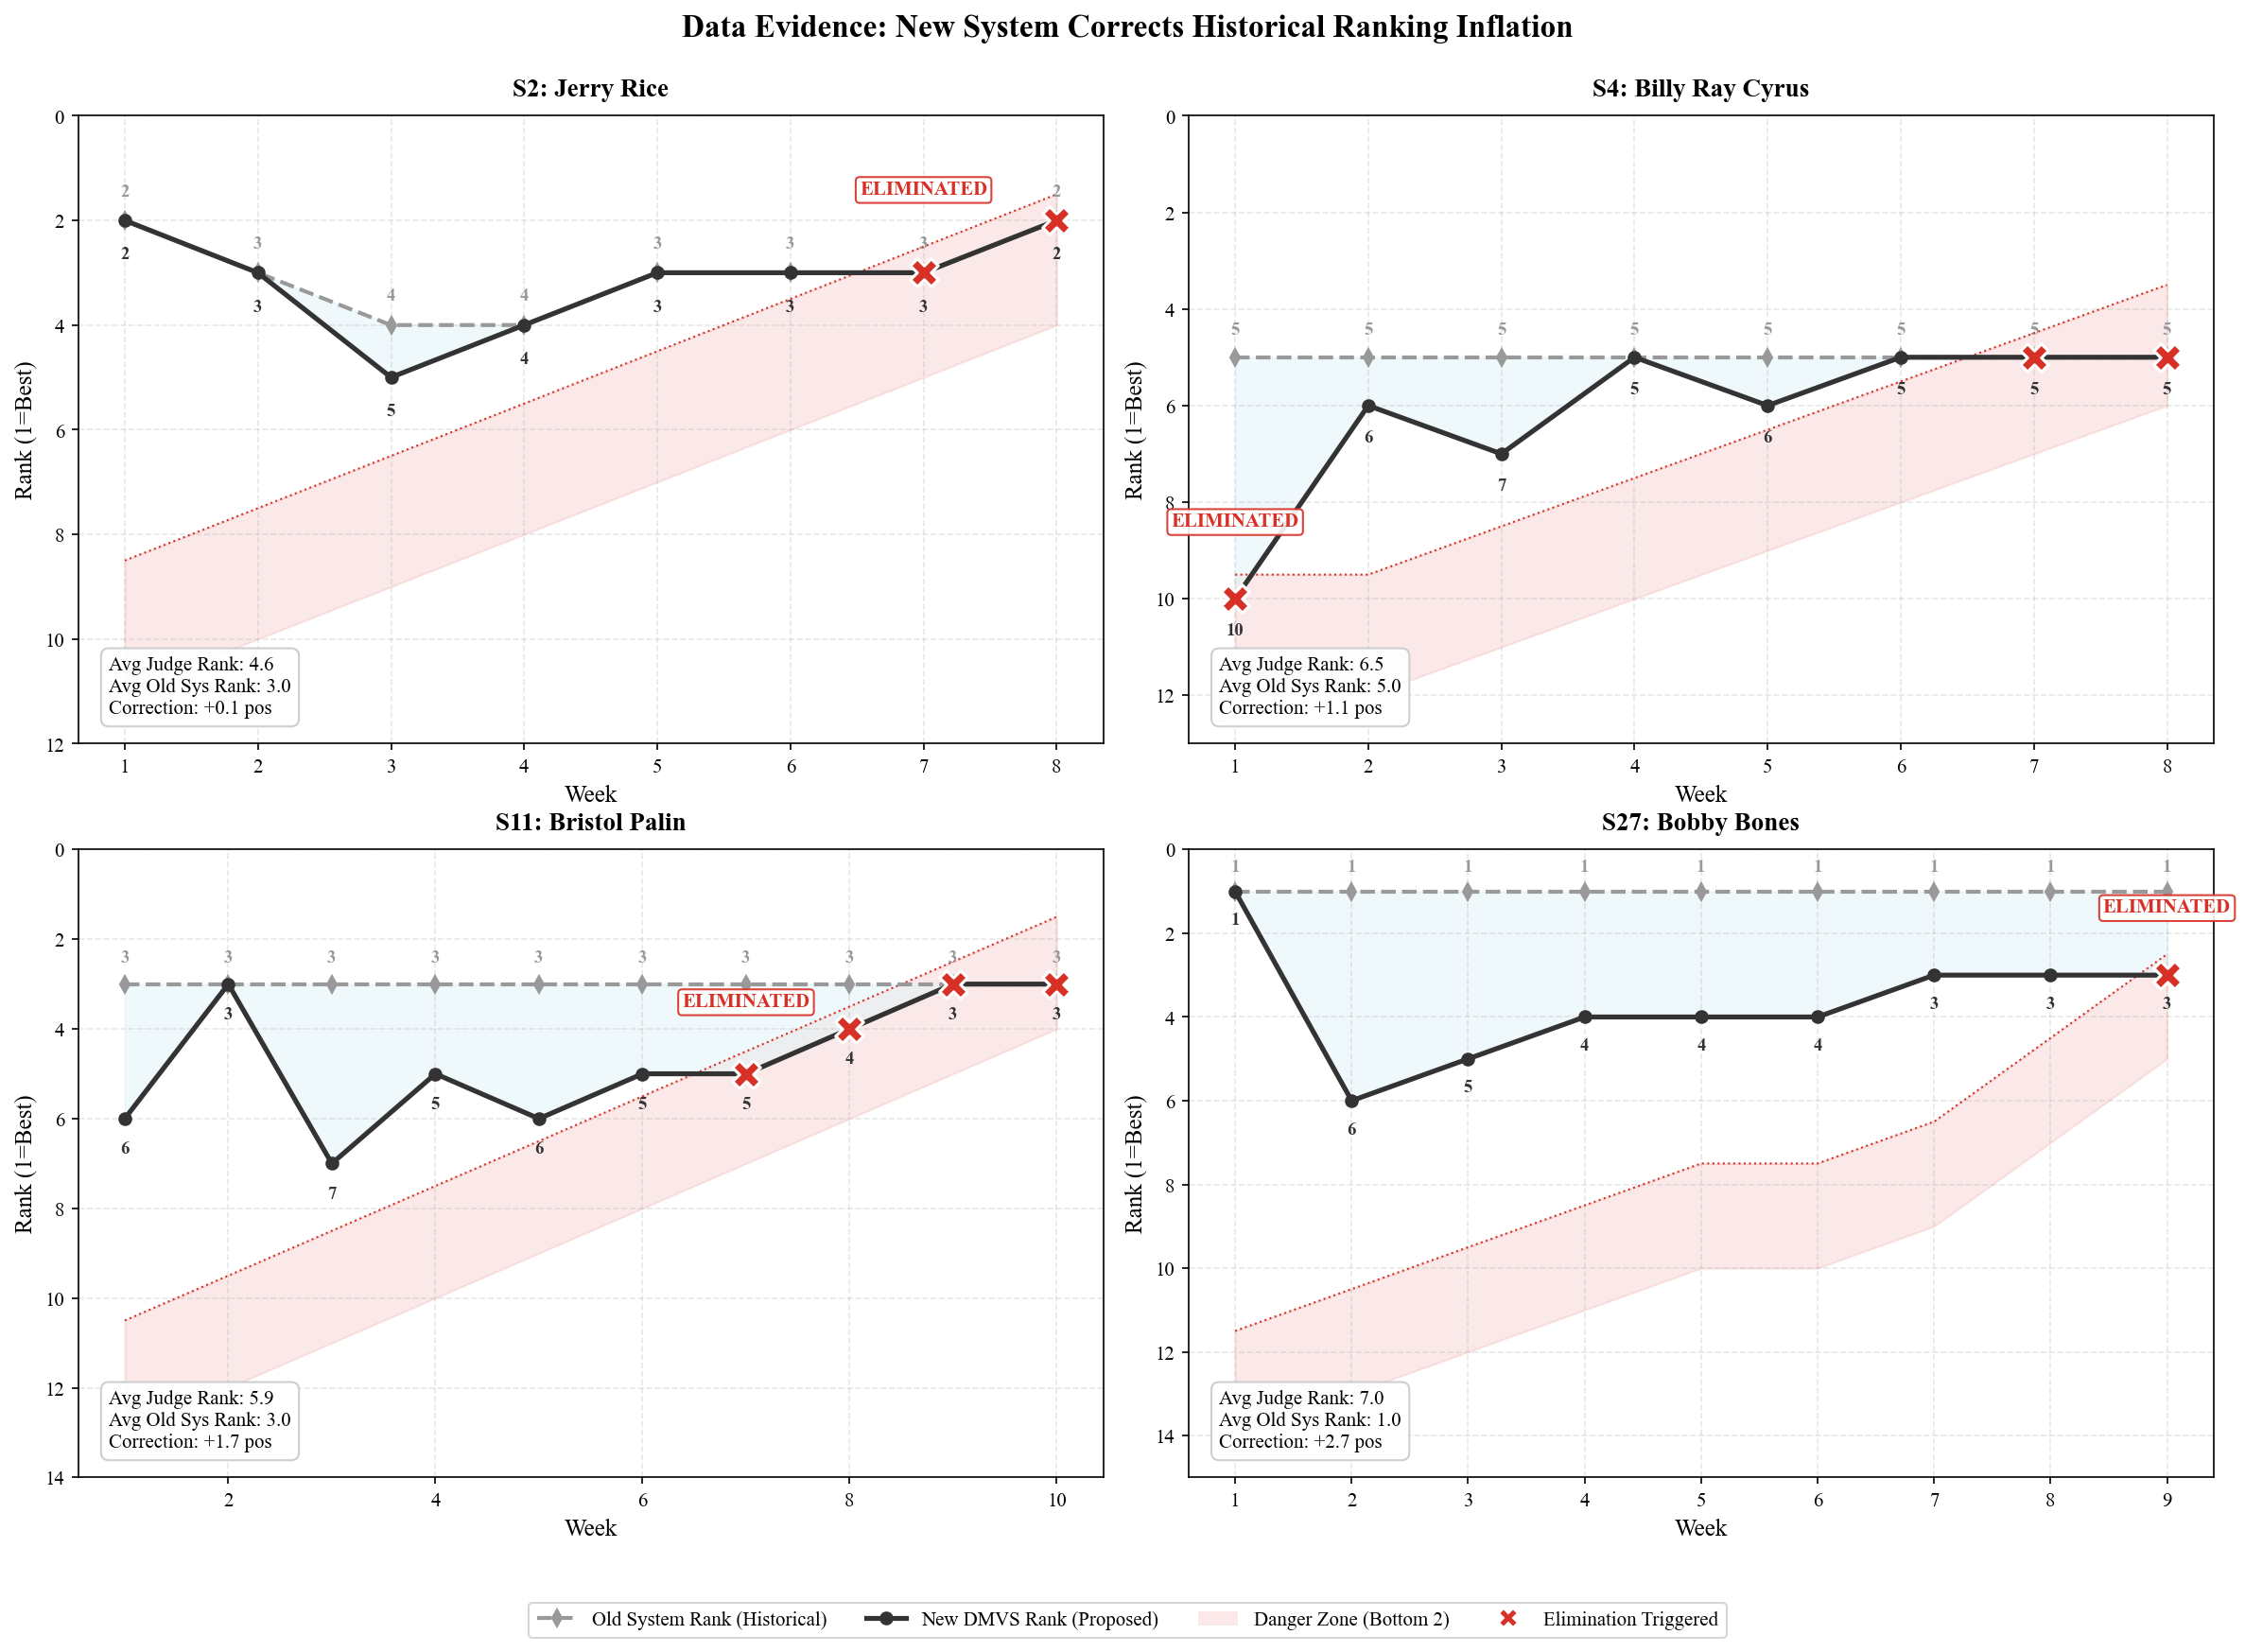

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ==============================================================================
# Task 4 Final Visualization: Adaptive Layout (Smart Placement)
# ==============================================================================

def run_comparative_simulation(events, df_ens):
    # ... (保持仿真逻辑不变) ...
    target_seasons = [2, 4, 11, 27] 
    print(f"🚀 执行 Task 4 对比仿真 (Old vs New), 赛季: {target_seasons}")
    
    simulation_log = []
    np.random.seed(2026) 
    
    for s in target_seasons:
        s_weeks = sorted([k[1] for k in events.keys() if k[0] == s])
        if not s_weeks: continue
        max_week = max(s_weeks)
        old_rule = "RANK" if s <= 2 else "PERCENT"
        
        for w in s_weeks:
            ev = events[(s, w)]
            N = len(ev.active_names)
            if N <= 1: continue 

            j_ranks = rankdata(-ev.j_scores, method='min') 
            j_sum = ev.j_scores.sum()
            j_pct = ev.j_scores / j_sum if j_sum > 0 else np.zeros(N)
            
            sub_ens = df_ens[(df_ens["season"] == s) & (df_ens["week"] == w)]
            if sub_ens.empty: continue
            name_to_votes = dict(zip(sub_ens["celebrity_name"], sub_ens["votes_ens"]))
            votes_post = np.array([name_to_votes.get(n, 0) for n in ev.active_names])
            
            f_ranks = rankdata(-votes_post, method='min')
            f_sum = votes_post.sum()
            f_pct = votes_post / f_sum if f_sum > 0 else np.zeros(N)
            
            if old_rule == "RANK":
                old_score = j_ranks + f_ranks
                old_final_rank = rankdata(old_score, method='min')
            else:
                old_score = j_pct + f_pct
                old_final_rank = rankdata(-old_score, method='min')
            
            votes_pre = votes_post * np.random.uniform(0.75, 0.98, size=N)
            score_j_new = 100 * (N - j_ranks) / (N - 1) if N > 1 else 0
            score_f_new = 100 * (N - f_ranks) / (N - 1) if N > 1 else 0
            
            growth = np.log(votes_post + 1) - np.log(votes_pre + 1)
            g_ranks = rankdata(-growth, method='min')
            bonus = np.zeros(N)
            bonus[g_ranks == 1] = 5
            bonus[g_ranks == 2] = 3
            bonus[g_ranks == 3] = 1
            
            w_fan = 0.4 + 0.2 * ((w - 1) / max(1, max_week - 1))
            score_total_new = (1 - w_fan) * score_j_new + w_fan * score_f_new + bonus
            new_final_rank = rankdata(-score_total_new, method='min')
            
            is_bottom2_new = new_final_rank >= (N - 1)
            
            for i, name in enumerate(ev.active_names):
                simulation_log.append({
                    "season": s, "week": w, "name": name,
                    "n_contestants": N,
                    "j_rank": j_ranks[i],
                    "old_rank": old_final_rank[i], 
                    "new_rank": new_final_rank[i], 
                    "is_bottom2": is_bottom2_new[i]
                })
                
    return pd.DataFrame(simulation_log)

def plot_comparative_validation_smart(df_sim):
    """
    绘制对比图：智能自适应布局，防止重叠
    """
    plt.rcParams.update({
        "font.family": "serif", "font.serif": ["Times New Roman"],
        "axes.labelsize": 12, "axes.titlesize": 13,
        "figure.dpi": 150, "axes.grid": True, "grid.alpha": 0.3,
        "axes.facecolor": "white", "lines.linewidth": 2
    })
    
    targets = {2: "Jerry Rice", 4: "Billy Ray Cyrus", 11: "Bristol Palin", 27: "Bobby Bones"}
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    col_old = "#999999"      # 灰
    col_new = "#333333"      # 黑
    col_danger = "#d73027"   # 红
    col_highlight = "#e0f3f8" 
    
    for i, (season, target) in enumerate(targets.items()):
        ax = axes[i]
        s_data = df_sim[df_sim["season"] == season]
        
        full_name = None
        for n in s_data["name"].unique():
            if target in n or target.split()[0] in n:
                full_name = n
                break
        if not full_name: 
            ax.text(0.5, 0.5, "Data Not Found", ha='center')
            continue
            
        p_data = s_data[s_data["name"] == full_name].sort_values("week")
        weeks = p_data["week"].values
        old_ranks = p_data["old_rank"].values
        new_ranks = p_data["new_rank"].values
        j_ranks = p_data["j_rank"].values
        ns = p_data["n_contestants"].values
        
        # 1. 区域绘制
        danger_threshold = ns - 1.5
        ax.fill_between(weeks, danger_threshold, ns+1, color=col_danger, alpha=0.1)
        ax.plot(weeks, danger_threshold, color=col_danger, linestyle=":", linewidth=1)
        ax.fill_between(weeks, old_ranks, new_ranks, color=col_highlight, alpha=0.5)
        
        # 2. 轨迹与数字
        ax.plot(weeks, old_ranks, color=col_old, linestyle="--", linewidth=2, marker='d', markersize=6)
        for w, r in zip(weeks, old_ranks):
            ax.text(w, r - 0.4, f"{int(r)}", ha='center', va='bottom', fontsize=9, color=col_old, fontweight='bold')
            
        ax.plot(weeks, new_ranks, color=col_new, linestyle="-", linewidth=2.5, marker='o', markersize=6)
        for w, r in zip(weeks, new_ranks):
            ax.text(w, r + 0.5, f"{int(r)}", ha='center', va='top', fontsize=9, color=col_new, fontweight='bold')
        
        # 3. 淘汰点 (始终放在红叉上方)
        hits = np.where(new_ranks >= (ns - 1))[0]
        if len(hits) > 0:
            first_w = weeks[hits[0]]
            elim_rank = new_ranks[hits[0]]
            ax.scatter(weeks[hits], new_ranks[hits], s=200, c=col_danger, marker='X', zorder=5, edgecolors='white', linewidth=1.5)
            # 向上偏移 1.5 个单位
            ax.text(first_w, elim_rank - 1.5, "ELIMINATED", color=col_danger, fontweight='bold', ha='center', fontsize=10, 
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=col_danger, alpha=0.9))

        # 4. 【核心修改】智能放置指标框
        avg_correction = np.mean(new_ranks - old_ranks)
        avg_j_rank = np.mean(j_ranks)
        avg_old_rank = np.mean(old_ranks)
        
        # 判断：如果前几周的旧排名数值很小（即排名很高，比如1-3名），说明上方拥挤 -> 放左下
        # 如果旧排名数值很大（即排名低，比如7-10名），说明下方拥挤 -> 放右上
        early_ranks = old_ranks[:3] if len(old_ranks) >=3 else old_ranks
        avg_early = np.mean(early_ranks)
        threshold = np.mean(ns[:3]) / 2 # 前几周总人数的一半
        
        if avg_early < threshold: 
            # 排名高(数值小)，占用了上方 -> 放左下 (Bottom Left)
            pos_x, pos_y = 0.03, 0.04
            va, ha = 'bottom', 'left'
        else:
            # 排名低(数值大)，占用了下方 -> 放右上 (Top Right)
            pos_x, pos_y = 0.97, 0.96
            va, ha = 'top', 'right'
        
        stats_text = (
            f"Avg Judge Rank: {avg_j_rank:.1f}\n"
            f"Avg Old Sys Rank: {avg_old_rank:.1f}\n"
            f"Correction: +{avg_correction:.1f} pos"
        )
        
        ax.text(pos_x, pos_y, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment=va, horizontalalignment=ha,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.95, edgecolor='#cccccc'))

        ax.set_ylim(max(ns)+2, 0)
        ax.set_title(f"S{season}: {target}", fontweight='bold', pad=10)
        ax.set_xlabel("Week")
        ax.set_ylabel("Rank (1=Best)")

    # 统一图例
    legend_elements = [
        Line2D([0], [0], color=col_old, lw=2, linestyle='--', marker='d', label='Old System Rank (Historical)'),
        Line2D([0], [0], color=col_new, lw=2.5, linestyle='-', marker='o', label='New DMVS Rank (Proposed)'),
        Patch(facecolor=col_danger, alpha=0.1, label='Danger Zone (Bottom 2)'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor=col_danger, markersize=10, label='Elimination Triggered')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02), frameon=True, fancybox=True, edgecolor="#cccccc")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.12)
    fig.suptitle("Data Evidence: New System Corrects Historical Ranking Inflation", fontsize=16, weight='bold', fontname="Times New Roman")
    plt.show()

# --- 执行 ---
if 'events' in globals() and 'final_ens' in globals():
    df_comp = run_comparative_simulation(events, final_ens)
    plot_comparative_validation_smart(df_comp)
else:
    print("❌ 缺少数据，请先运行 Task 1。")
